In [2]:
import sys
sys.path.append('./utils')  # make sure Python knows where to look

import os
os.environ['DYLD_INSERT_LIBRARIES'] = ''
if 'MallocStackLogging' in os.environ:
    del os.environ['MallocStackLogging']

import numpy as np
# Fix deprecated np.int for NumPy 1.20+ (mlens library still uses deprecated aliases)
if not hasattr(np, 'int'):
    np.int = np.int64
    np.float = np.float64
    np.complex = np.complex128
    np.object = np.object_
    np.str = np.str_
    np.long = np.int64
    np.unicode = np.str_

# Display full output in Jupyter
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

import datetime
import pandas as pd
from sklearn.base import clone
from numpy import hstack, vstack
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_auc_score, average_precision_score

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import ml_training_functions as utils_training
import file_handler_functions as utils_file


In [3]:
# Load data from the 2018-07-25 to the 2018-08-14
DIR_INPUT='./data/simulated-data-transformed/' 

BEGIN_DATE = "2018-06-11"
END_DATE = "2018-08-14"

print("Load  files")
%time transactions_df = utils_file.read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))

START_DATE = "2018-07-25"
delta_train = delta_delay = delta_test = delta_valid = delta_assessment = 7

# Number of folds for the prequential validation
n_folds = 4

start_date_training = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
start_date_test = start_date_training+datetime.timedelta(days=delta_train+delta_delay)

start_date_training_for_valid = start_date_training+datetime.timedelta(days=-(delta_delay+delta_valid))
start_date_training_for_test = start_date_training+datetime.timedelta(days=(n_folds-1)*delta_test)

Load  files
CPU times: user 111 ms, sys: 185 ms, total: 296 ms
Wall time: 471 ms
622892 transactions loaded, containing 5515 fraudulent transactions


In [4]:
output_feature = "TX_FRAUD"

input_features = ['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']

# Only keep columns that are needed as argument to the custom scoring function
# (in order to reduce the serialization time of transaction dataset)
transactions_df_scorer = transactions_df[['CUSTOMER_ID', 'TX_FRAUD','TX_TIME_DAYS']]

# Split dataset for Cross validation
prequential_split_indices=utils_training.prequentialSplit(transactions_df,
                                               start_date_training=start_date_training, 
                                               n_folds=n_folds, 
                                               delta_train=delta_train, 
                                               delta_delay=delta_delay, 
                                               delta_assessment=delta_assessment)


In [5]:
def get_base_models_tuning():
    return {
        'XGBClassifier': XGBClassifier(
            learning_rate = 0.3,
            max_depth = 3,
            n_estimators = 100,
            n_jobs = -1,
            random_state = 0,
            scale_pos_weight = 10
        ),
        'LGBMClassifier': LGBMClassifier(
            learning_rate = 0.1,
            max_depth = 3,
            n_estimators = 100,
            n_jobs=-1,
            random_state=0,
            scale_pos_weight=1, 
            verbosity=-1
        ),
        'CatBoostClassifier': CatBoostClassifier(
            depth = 4,
            iterations = 500,
            learning_rate = 0.05,
            random_state = 0,
            scale_pos_weight = 5,
            # prefer class_weights if heavy imbalance; we'll rely on default + tuned params
            # class_weights can be added if desired, e.g. class_weights=[1, 99]
            verbose = 0
        ),
        'HistGradientBoostingClassifier': HistGradientBoostingClassifier(
            max_iter = 100,
            learning_rate = 0.05,
            max_depth = 5,
            random_state = 0,
            class_weight = 'balanced'
        ),
        'BalancedRandomForestClassifier': BalancedRandomForestClassifier(
            max_depth = 20,
            n_estimators = 100,
            n_jobs = -1,
            random_state = 0,
            sampling_strategy = 0.05
        ),
        'BalancedBaggingClassifier': BalancedBaggingClassifier(
            bootstrap = True,
            estimator = DecisionTreeClassifier(max_depth=20, random_state=0),
            n_estimators = 100,
            n_jobs = -1,
            random_state = 0,
            sampler = RandomUnderSampler(),
            sampling_strategy = 0.1
        ),
        'LogisticRegression': LogisticRegression(
            C=0.1,
            random_state=0,
            class_weight='balanced'
        )
    }
    
def get_base_models():
    return {
        'XGBClassifier': XGBClassifier(
            learning_rate = 0.1,
            max_depth = 3,
            n_estimators = 50,
            n_jobs = -1,
            random_state = 0,
            scale_pos_weight = 10
        ),
        'LGBMClassifier': LGBMClassifier(
            learning_rate = 0.1,
            max_depth = 3,
            n_estimators = 50,
            n_jobs=-1,
            random_state=0,
            scale_pos_weight=1
        ),
        'CatBoostClassifier': CatBoostClassifier(
            depth = 4,
            iterations = 500,
            learning_rate = 0.05,
            random_state = 0,
            class_weights=[1, 99],
            verbose = 0
        ),
        'HistGradientBoostingClassifier': HistGradientBoostingClassifier(
            max_iter = 100,
            learning_rate = 0.05,
            max_depth = 5,
            random_state = 0,
            class_weight = 'balanced'
        ),
        'BalancedRandomForestClassifier': BalancedRandomForestClassifier(
            max_depth = 50,
            n_estimators = 100,
            n_jobs = -1,
            random_state = 0,
            sampling_strategy = 0.1
        ),
        'BalancedBaggingClassifier': BalancedBaggingClassifier(
            bootstrap = True,
            estimator = DecisionTreeClassifier(max_depth=20, random_state=0),
            n_estimators = 100,
            n_jobs = -1,
            random_state = 0,
            sampler = RandomUnderSampler(),
            sampling_strategy = 0.1
        ),
        'LogisticRegression': LogisticRegression(
            class_weight='balanced',
            C=0.1,
            random_state=0,
            solver='liblinear'
        ),
    }

# for this function, the transactions_df_scorer must contain CUSTOMER_ID and TX_TIME_DAYS for the full df; X_index are the indices for the current test fold.
def card_precision_top_k_wrapper(probs, X_index, transactions_df_scorer, k=100):
    preds_df = transactions_df_scorer.loc[X_index].copy()
    preds_df['predictions'] = probs
    nb, per_day_list, mean_cp = utils_training.card_precision_top_k(preds_df, k)
    return mean_cp

# out-of-fold builder (prequential-friendly)
def get_out_of_fold_predictions_no_sampling(transactions_df, prequential_split_indices, base_models_dict,
                                           input_features, output_feature, transactions_df_scorer=None):
    meta_rows = []
    meta_labels = []
    meta_indices = []
    model_names = list(base_models_dict.keys())

    # iterate prequential folds
    for fold_i, (train_ix, test_ix) in enumerate(prequential_split_indices):
        # get train/test slices (no sampling)
        train_df = transactions_df.iloc[train_ix]
        test_df = transactions_df.iloc[test_ix]
        X_train, y_train, X_test, y_test = get_train_test_features(train_df, test_df, input_features, output_feature)

        # scale: fit scaler on training fold only, transform train/test
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # collect base model predictions
        fold_preds = []

        for name in model_names:
            # initailized a new model instance on different fold
            model = clone(base_models_dict[name]) 
            model.fit(X_train_scaled, y_train)
            probs = utils_training.get_predict_proba(model, X_test_scaled)

            fold_preds.append(probs.reshape(-1, 1))

        # stack column-wise to shape (n_test_rows, n_models)
        fold_meta_X = np.hstack(fold_preds)

        meta_rows.append(fold_meta_X)
        meta_labels.append(y_test)
        
        # keep original indices for evaluation (card precision)
        meta_indices.append(test_df.index)

    # vertically stack folds
    meta_X = np.vstack(meta_rows)
    meta_y = np.concatenate(meta_labels)
    meta_index = np.concatenate([np.array(idx) for idx in meta_indices])

    return meta_X, meta_y, meta_index, model_names

# Fit base models on full training data (no sampling)
def fit_base_models_full(X_train_df, y_train_series, base_models_dict):
    fitted_models = {}
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_df.values)   # we will also store this scaler for test transforms if needed
    for name, model in base_models_dict.items():
        m = clone(model)
        m.fit(X_train_scaled, y_train_series.values)
        fitted_models[name] = m
    return fitted_models, scaler

# Fit meta model (LogisticRegression) on meta features
def fit_meta_model(base_models, meta_X, meta_y):
    meta_model = base_models['LogisticRegression']
    meta_model.fit(meta_X, meta_y)
    return meta_model

# Super-learner prediction helper for producing probability predictions on test set
def super_learner_predict_proba(models_fitted_dict, meta_model, X_test_df, scaler=None):
    # transform X_test appropriately (if scaler provided)
    if scaler is not None:
        X_test_scaled = scaler.transform(X_test_df.values)
    else:
        X_test_scaled = X_test_df.values

    probs_list = []
    for _, model in models_fitted_dict.items():
        probs = utils_training.get_predict_proba(model, X_test_scaled)
        probs_list.append(probs)
        
    meta_X_test = np.hstack(probs_list)
    
    # meta_model should support predict_proba
    if hasattr(meta_model, "predict_proba"):
        return meta_model.predict_proba(meta_X_test)[:, 1]
    else:
        # fallback
        return meta_model.predict(meta_X_test)

def get_train_test_features(train_df, test_df, input_features, output_feature):
    return (train_df[input_features].values, 
            train_df[output_feature].values,
            test_df[input_features].values,
            test_df[output_feature].values)

def get_performance_metrics(df, y, probs, transactions_df_scorer):
    auc = roc_auc_score(y, probs)
    ap  = average_precision_score(y, probs)
    cp = None
    if transactions_df_scorer is not None:
        cp = card_precision_top_k_wrapper(probs, df.index, transactions_df_scorer, k=100)
        
    return auc, ap, cp
    
def evaluate_base_models_per_fold(base_models_dict, train_df, test_df,
                                  input_features, output_feature,
                                  transactions_df_scorer=None):
    X_train, y_train, X_test, y_test = get_train_test_features(train_df, test_df, input_features, output_feature)

    # scale using train only
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    fold_results = {}

    for name, model in base_models_dict.items():
        m = clone(model)
        m.fit(X_train_scaled, y_train)

        # Predicting train set and test set
        train_probs = utils_training.get_predict_proba(m, X_train_scaled)
        test_probs = utils_training.get_predict_proba(m, X_test_scaled)
        
        train_auc, train_ap, train_cp = get_performance_metrics(train_df, y_train, train_probs, transactions_df_scorer)
        test_auc, test_ap, test_cp = get_performance_metrics(test_df, y_test, test_probs, transactions_df_scorer)

        train_performance_detail = {'n_train': len(train_df), 'auc': train_auc, 'ap': train_ap, 'cp100': train_cp}
        test_performance_detail = {'n_train': len(test_df), 'auc': test_auc, 'ap': test_ap, 'cp100': test_cp}
        fold_results[name] = {'train': train_performance_detail, 'test': test_performance_detail}

    return fold_results


def evaluate_super_learner_per_fold(fitted_base_models, meta_model,
                                    train_df, test_df,
                                    input_features, output_feature,
                                    scaler, transactions_df_scorer=None):
    X_train, y_train, X_test, y_test = get_train_test_features(train_df, test_df, input_features, output_feature)

    # scale test set with global scaler
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    # build meta features for train
    train_meta = []
    for m in fitted_base_models.values():
        train_probs = utils_training.get_predict_proba(m, X_train_scaled)
        train_meta.append(train_probs.reshape(-1, 1))
    X_train_meta = np.hstack(train_meta)

    # build meta features for test
    test_meta = []
    for m in fitted_base_models.values():
        test_probs = utils_training.get_predict_proba(m, X_test_scaled)
        test_meta.append(test_probs.reshape(-1, 1))
    X_test_meta = np.hstack(test_meta)

    # predict using meta model
    train_probs = meta_model.predict_proba(X_train_meta)[:, 1]
    test_probs  = meta_model.predict_proba(X_test_meta)[:, 1]
    
    train_auc, train_ap, train_cp = get_performance_metrics(train_df, y_train, train_probs, transactions_df_scorer)
    test_auc, test_ap, test_cp = get_performance_metrics(test_df, y_test, test_probs, transactions_df_scorer)

    train_performance_detail = {'n_train': len(train_df), 'auc': train_auc, 'ap': train_ap, 'cp100': train_cp}
    test_performance_detail = {'n_train': len(test_df), 'auc': test_auc, 'ap': test_ap, 'cp100': test_cp}
    return {'train': train_performance_detail, 'test': test_performance_detail}

def summarize_performance_across_folds(per_fold_results):
    train_auc = []
    train_ap = []
    train_cp = []
    test_auc = []
    test_ap = []
    test_cp = []

    for item in per_fold_results:
        r_train = item['results']['train']
        r_test  = item['results']['test']

        train_auc.append(r_train['auc'])
        train_ap.append(r_train['ap'])
        train_cp.append(r_train['cp100'])

        test_auc.append(r_test['auc'])
        test_ap.append(r_test['ap'])
        test_cp.append(r_test['cp100'])

    return {
        'train_auc_mean': f'{np.mean(train_auc):.4f}',
        'train_ap_mean': f'{np.mean(train_ap):.4f}',
        'train_cp100_mean': f'{np.mean(train_cp):.4f}',
        'test_auc_mean': f'{np.mean(test_auc):.4f}',
        'test_ap_mean': f'{np.mean(test_ap):.4f}',
        'test_cp100_mean': f'{np.mean(test_cp):.4f}',
    }

# Full pipeline runner (ties everything together)
def run_super_learner(base_models, transactions_df, prequential_split_indices,
                              input_features, output_feature,
                              transactions_df_scorer=None, verbose=True):

    # -------------------- OOF meta features --------------------
    meta_X, meta_y, meta_index, model_names = get_out_of_fold_predictions_no_sampling(
        transactions_df, prequential_split_indices, base_models,
        input_features, output_feature, transactions_df_scorer
    )
    meta_model = fit_meta_model(base_models, meta_X, meta_y)

    # -------------------- fit base models on first window --------------------
    first_train_ix, _ = prequential_split_indices[0]
    train_df_full = transactions_df.iloc[first_train_ix]
    X_train_full = train_df_full[input_features]
    y_train_full = train_df_full[output_feature]

    fitted_base_models, global_scaler = fit_base_models_full(
        X_train_full, y_train_full, base_models
    )

    # -------------------- Evaluate per fold --------------------
    super_learner_performance = []
    base_model_performance = {name: [] for name in base_models.keys()}

    for fold_i, (train_ix, test_ix) in enumerate(prequential_split_indices):
        train_df = transactions_df.iloc[train_ix]
        test_df  = transactions_df.iloc[test_ix]

        # ---- base models per fold ----
        base_fold_result = evaluate_base_models_per_fold(
            base_models, train_df, test_df,
            input_features, output_feature,
            transactions_df_scorer
        )
        for model_name, metrics in base_fold_result.items():
            base_model_performance[model_name].append({'fold': fold_i, 'results': metrics})

        # ---- super learner per fold ----
        super_learner_fold_result = evaluate_super_learner_per_fold(
            fitted_base_models, meta_model,
            train_df, test_df,
            input_features, output_feature,
            global_scaler, transactions_df_scorer
        )
        super_learner_performance.append({'fold': fold_i, 'results': super_learner_fold_result })

    return {
        'meta_model': meta_model,
        'fitted_base_models': fitted_base_models,
        'global_scaler': global_scaler,
        'base_model_performance': base_model_performance,
        'super_learner_performance': super_learner_performance
    }


In [6]:
base_models = get_base_models()

preformance_results = run_super_learner(base_models, transactions_df, prequential_split_indices,
                            input_features, output_feature,
                            transactions_df_scorer=transactions_df_scorer,
                            verbose=True)

[LightGBM] [Info] Number of positive: 598, number of negative: 66642
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1620
[LightGBM] [Info] Number of data points in the train set: 67240, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008894 -> initscore=-4.713500
[LightGBM] [Info] Start training from score -4.713500
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [7]:
res = {}
res["SuperLearner"] = summarize_performance_across_folds(preformance_results['super_learner_performance'])
for name, performance_result in preformance_results['base_model_performance'].items():
    res[name] = summarize_performance_across_folds(performance_result)
    
pd.DataFrame.from_dict(res, orient='index')

,train_auc_mean,train_ap_mean,train_cp100_mean,test_auc_mean,test_ap_mean,test_cp100_mean
SuperLearner,0.9256,0.8018,0.4521,0.9078,0.7593,0.3229
XGBClassifier,0.9343,0.7378,0.4264,0.8719,0.6318,0.2921
LGBMClassifier,0.9469,0.7774,0.4311,0.8794,0.6488,0.2896
CatBoostClassifier,0.9945,0.7950,0.4636,0.8816,0.6065,0.2921
HistGradientBoostingClassifier,0.9724,0.7660,0.4354,0.8541,0.6004,0.2754
BalancedRandomForestClassifier,1.0000,1.0000,0.5464,0.8811,0.6549,0.2914
BalancedBaggingClassifier,0.9994,0.9489,0.5350,0.8804,0.6913,0.2929
LogisticRegression,0.8996,0.5941,0.3982,0.8704,0.5419,0.2825


In [8]:
base_models = get_base_models_tuning()

preformance_results_tuning = run_super_learner(base_models, transactions_df, prequential_split_indices,
                            input_features, output_feature,
                            transactions_df_scorer=transactions_df_scorer,
                            verbose=True)

In [9]:
res = {}
res["SuperLearner"] = summarize_performance_across_folds(preformance_results_tuning['super_learner_performance'])
for name, performance_result in preformance_results_tuning['base_model_performance'].items():
    res[name] = summarize_performance_across_folds(performance_result)
    
pd.DataFrame.from_dict(res, orient='index')

,train_auc_mean,train_ap_mean,train_cp100_mean,test_auc_mean,test_ap_mean,test_cp100_mean
SuperLearner,0.9244,0.7989,0.4475,0.9082,0.7538,0.3214
XGBClassifier,0.9934,0.8701,0.4746,0.8798,0.6445,0.2864
LGBMClassifier,0.9660,0.8100,0.4379,0.8856,0.6535,0.2893
CatBoostClassifier,0.9710,0.8322,0.4454,0.8860,0.6721,0.2943
HistGradientBoostingClassifier,0.9724,0.7660,0.4354,0.8541,0.6004,0.2754
BalancedRandomForestClassifier,0.9991,0.9460,0.5189,0.8844,0.6673,0.2904
BalancedBaggingClassifier,0.9994,0.9489,0.5350,0.8804,0.6913,0.2929
LogisticRegression,0.8996,0.5940,0.3982,0.8704,0.5418,0.2825


## Export Model

In [10]:
import joblib
import os

FOLDER_PATH = "./models"
FILE_PATH = FOLDER_PATH+"/super_learner_model.pkl"

os.makedirs(FOLDER_PATH, exist_ok=True)

joblib.dump({
    'base_models': preformance_results_tuning['fitted_base_models'],
    'meta_model': preformance_results_tuning['meta_model'],
    'scaler': preformance_results_tuning['global_scaler'],
    'input_features': input_features,
}, FILE_PATH)

['./models/super_learner_model.pkl']

## Load model to simulate new transaction prediction

In [11]:

import os
import sys
import joblib
import json
import pandas as pd

sys.path.append('./models')
sys.path.append('./utils')

import transform_data_functions as utils_transform
import ml_training_functions as utils_training

FOLDER_PATH = "./models"
FILE_PATH = FOLDER_PATH + "/super_learner_model.pkl"

if not os.path.isdir(FOLDER_PATH):
    raise NotADirectoryError(f"Error: The folder '{FOLDER_PATH}' does not exist.")

if not os.path.isfile(FILE_PATH):
    raise FileNotFoundError(f"Error: The file '{FILE_PATH}' does not exist.")

load_model = joblib.load(FILE_PATH)

In [12]:
train_ix, _ = prequential_split_indices[0]
train_ix[:10]

[421597,
 421598,
 421599,
 421600,
 421601,
 421602,
 421603,
 421604,
 421605,
 421606]

In [13]:
train_df = transactions_df.iloc[train_ix[:1]]
X_train = train_df[input_features]
y_train = train_df[output_feature]
X_train

,TX_AMOUNT,TX_DURING_WEEKEND,TX_DURING_NIGHT,CUSTOMER_ID_NB_TX_1DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW
421597,40.77,0,1,2.0,29.005,24.0,29.19125,105.0,30.14181,1.0,0.0,10.0,0.0,32.0,0.0


In [14]:
load_model

{'base_models': {'XGBClassifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                feature_weights=None, gamma=None, grow_policy=None,
                importance_type=None, interaction_constraints=None,
                learning_rate=0.3, max_bin=None, max_cat_threshold=None,
                max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
                max_leaves=None, min_child_weight=None, missing=nan,
                monotone_constraints=None, multi_strategy=None, n_estimators=100,
                n_jobs=-1, num_parallel_tree=None, ...),
  'LGBMClassifier': LGBMClassifier(max_depth=3, n_jobs=-1, random_state=0, scale_pos_weight=1,
                 verbosity=-1),
  'CatBoostClassifier': <catboost.core.CatBoostClassifier at 0x2

In [15]:
scaler = load_model['scaler']
X_test_scaled  = scaler.transform(X_train)
X_test_scaled

array([[-3.03662917e-01, -6.28230471e-01,  2.18147233e+00,
        -8.49809150e-01, -7.03151208e-01,  6.55714317e-01,
        -8.00291332e-01,  9.34421970e-01, -8.01283291e-01,
         2.47708159e-04, -7.58364225e-02,  1.00582896e+00,
        -1.18079962e-01,  2.41362527e-01, -1.47825083e-01]])

In [16]:
base_models = load_model['base_models']
meta_model = load_model['meta_model']

test_meta = []
for m in base_models.values():
    base_test_prob = utils_training.get_predict_proba(m, X_test_scaled)
    test_meta.append(base_test_prob.reshape(-1, 1))
X_test_meta = np.hstack(test_meta)
test_prob  = meta_model.predict_proba(X_test_meta)[:, 1]
test_prob

array([0.19168006])

## SHAP Analysis for Model Interpretability

In [17]:
import shap
import matplotlib.pyplot as plt

# Create shortened feature names for better visualization
feature_name_mapping = {
    'TX_AMOUNT': 'Amount',
    'TX_DURING_WEEKEND': 'Weekend',
    'TX_DURING_NIGHT': 'Night',
    'CUSTOMER_ID_NB_TX_1DAY_WINDOW': 'Cust_Tx_1d',
    'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW': 'Cust_Avg_1d',
    'CUSTOMER_ID_NB_TX_7DAY_WINDOW': 'Cust_Tx_7d',
    'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW': 'Cust_Avg_7d',
    'CUSTOMER_ID_NB_TX_30DAY_WINDOW': 'Cust_Tx_30d',
    'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW': 'Cust_Avg_30d',
    'TERMINAL_ID_NB_TX_1DAY_WINDOW': 'Term_Tx_1d',
    'TERMINAL_ID_RISK_1DAY_WINDOW': 'Term_Risk_1d',
    'TERMINAL_ID_NB_TX_7DAY_WINDOW': 'Term_Tx_7d',
    'TERMINAL_ID_RISK_7DAY_WINDOW': 'Term_Risk_7d',
    'TERMINAL_ID_NB_TX_30DAY_WINDOW': 'Term_Tx_30d',
    'TERMINAL_ID_RISK_30DAY_WINDOW': 'Term_Risk_30d'
}

short_feature_names = [feature_name_mapping[f] for f in input_features]
print(f"Original features: {len(input_features)}")
print(f"Shortened names: {short_feature_names}")

Original features: 15
Shortened names: ['Amount', 'Weekend', 'Night', 'Cust_Tx_1d', 'Cust_Avg_1d', 'Cust_Tx_7d', 'Cust_Avg_7d', 'Cust_Tx_30d', 'Cust_Avg_30d', 'Term_Tx_1d', 'Term_Risk_1d', 'Term_Tx_7d', 'Term_Risk_7d', 'Term_Tx_30d', 'Term_Risk_30d']


In [18]:
# Prepare test data sample for SHAP analysis (using last fold's test set)
_, test_ix = prequential_split_indices[-1]
test_df_shap = transactions_df.iloc[test_ix]
X_test_shap = test_df_shap[input_features].copy()
y_test_shap = test_df_shap[output_feature]

# Scale the test data
scaler_shap = preformance_results_tuning['global_scaler']
X_test_scaled_shap = scaler_shap.transform(X_test_shap)

# Sample 1000 rows for SHAP computation (for efficiency)
sample_size = min(1000, len(X_test_scaled_shap))
sample_indices = np.random.choice(len(X_test_scaled_shap), sample_size, replace=False)
X_shap_sample = X_test_scaled_shap[sample_indices]

print(f"SHAP sample size: {X_shap_sample.shape}")
print(f"Test set size: {len(X_test_shap)}")
print(f"Fraud rate in test: {y_test_shap.mean():.4f}")

SHAP sample size: (1000, 15)
Test set size: 57931
Fraud rate in test: 0.0061


### SHAP Analysis for XGBoost Base Learner

In [19]:
# XGBoost SHAP Analysis
xgb_model = preformance_results_tuning['fitted_base_models']['XGBClassifier']

# Use TreeExplainer for XGBoost (efficient for tree models)
explainer_xgb = shap.TreeExplainer(xgb_model)
shap_values_xgb = explainer_xgb.shap_values(X_shap_sample)

print(f"XGBoost SHAP values shape: {shap_values_xgb.shape}")

XGBoost SHAP values shape: (1000, 15)


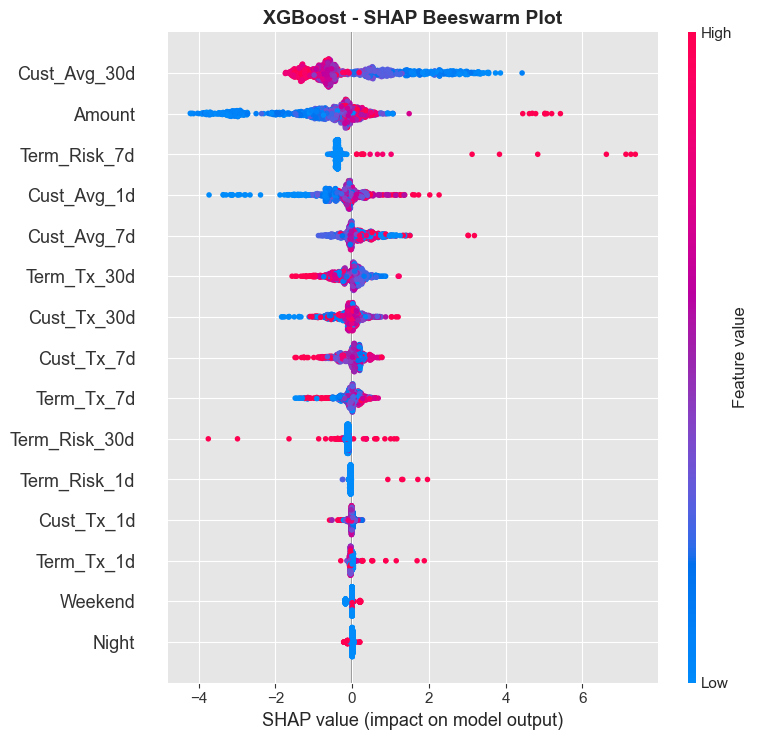

In [20]:
# XGBoost Beeswarm Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
shap.summary_plot(shap_values_xgb, X_shap_sample, 
                  feature_names=short_feature_names,
                  show=False, max_display=15)
plt.title("XGBoost - SHAP Beeswarm Plot", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

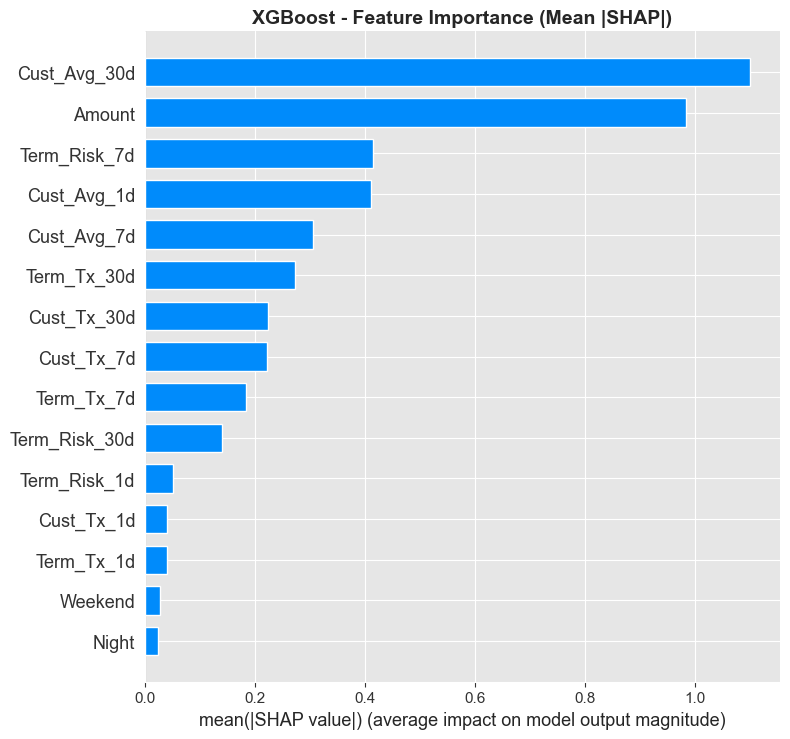

In [21]:
# XGBoost Feature Importance (Mean Absolute SHAP)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
shap.summary_plot(shap_values_xgb, X_shap_sample,
                  feature_names=short_feature_names,
                  plot_type="bar", show=False, max_display=15)
plt.title("XGBoost - Feature Importance (Mean |SHAP|)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### SHAP Analysis for Logistic Regression (Meta-Learner)

In [22]:
# For Logistic Regression, we'll analyze it as a base learner (not meta-learner)
# The meta-learner uses base model predictions as features, not original features
logreg_model = preformance_results_tuning['fitted_base_models']['LogisticRegression']

# Use LinearExplainer for Logistic Regression (efficient for linear models)
explainer_logreg = shap.LinearExplainer(logreg_model, X_shap_sample, feature_perturbation="interventional")
shap_values_logreg = explainer_logreg.shap_values(X_shap_sample)

print(f"LogisticRegression SHAP values shape: {shap_values_logreg.shape}")

LogisticRegression SHAP values shape: (1000, 15)


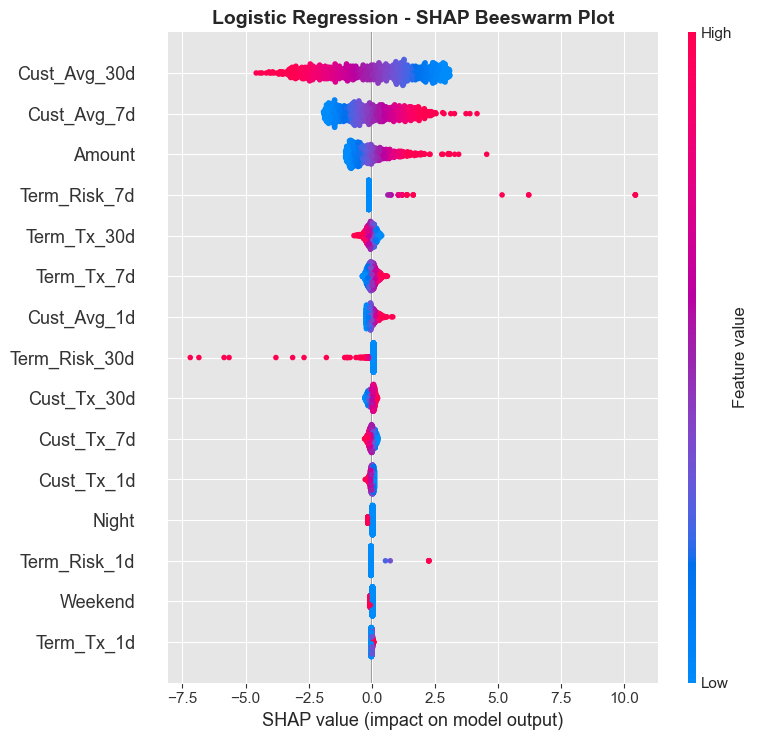

In [23]:
# Logistic Regression Beeswarm Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
shap.summary_plot(shap_values_logreg, X_shap_sample,
                  feature_names=short_feature_names,
                  show=False, max_display=15)
plt.title("Logistic Regression - SHAP Beeswarm Plot", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

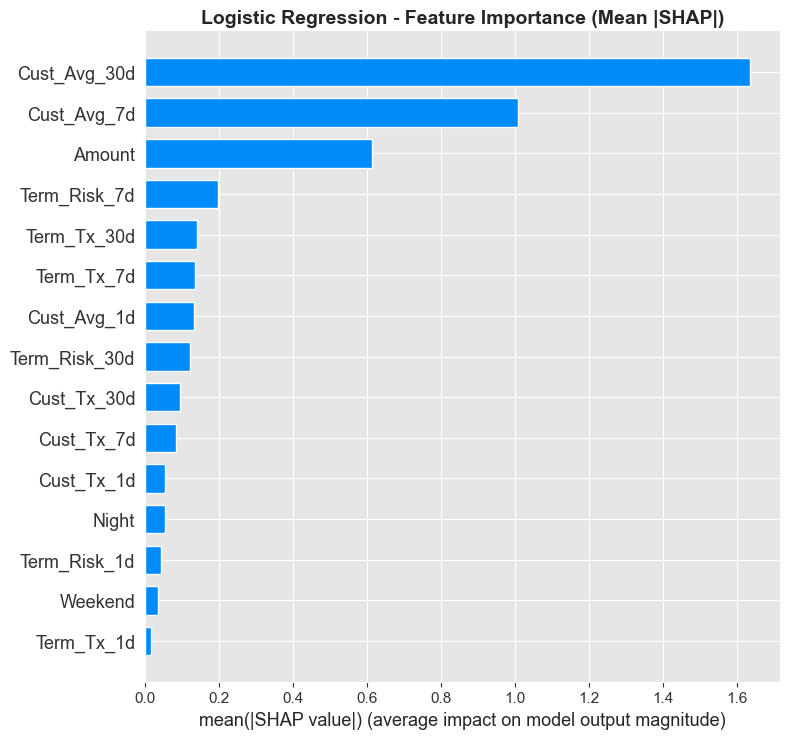

In [24]:
# Logistic Regression Feature Importance (Mean Absolute SHAP)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
shap.summary_plot(shap_values_logreg, X_shap_sample,
                  feature_names=short_feature_names,
                  plot_type="bar", show=False, max_display=15)
plt.title("Logistic Regression - Feature Importance (Mean |SHAP|)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### SHAP Analysis for Super Learner

In [28]:
# For Super Learner, we need to create a wrapper that combines base models + meta-learner
class SuperLearnerWrapper:
    def __init__(self, base_models, meta_model):
        self.base_models = base_models
        self.meta_model = meta_model
    
    def predict(self, X):
        """Predict fraud probability (class 1) using the super learner pipeline"""
        # Generate base model predictions
        meta_features = []
        for model in self.base_models.values():
            pred = utils_training.get_predict_proba(model, X)
            meta_features.append(pred.reshape(-1, 1))
        X_meta = np.hstack(meta_features)
        
        # Meta-learner prediction - return probability of fraud (class 1)
        return self.meta_model.predict_proba(X_meta)[:, 1]

# Create super learner wrapper
super_learner = SuperLearnerWrapper(
    preformance_results_tuning['fitted_base_models'],
    preformance_results_tuning['meta_model']
)

# Use KernelExplainer for the super learner (model-agnostic approach)
# Sample background data for KernelExplainer (50 samples for efficiency)
background_sample = shap.sample(X_shap_sample, min(50, len(X_shap_sample)))
explainer_sl = shap.KernelExplainer(super_learner.predict, background_sample)

# Compute SHAP values (use smaller sample for efficiency due to KernelExplainer cost)
shap_sample_sl = X_shap_sample[:min(100, len(X_shap_sample))]
shap_values_sl = explainer_sl.shap_values(shap_sample_sl)

print(f"SuperLearner SHAP values shape: {shap_values_sl.shape}")
print(f"SuperLearner SHAP values type: {type(shap_values_sl)}")

100%|██████████| 100/100 [02:20<00:00,  1.41s/it]

SuperLearner SHAP values shape: (100, 15)
SuperLearner SHAP values type: <class 'numpy.ndarray'>


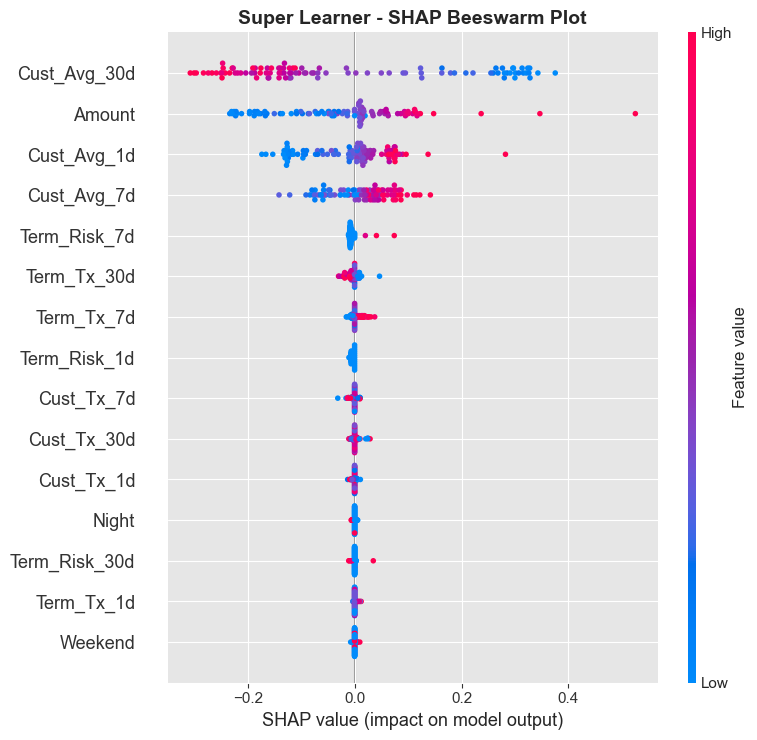

In [29]:
# Super Learner Beeswarm Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
shap.summary_plot(shap_values_sl, shap_sample_sl,
                  feature_names=short_feature_names,
                  show=False, max_display=15)
plt.title("Super Learner - SHAP Beeswarm Plot", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

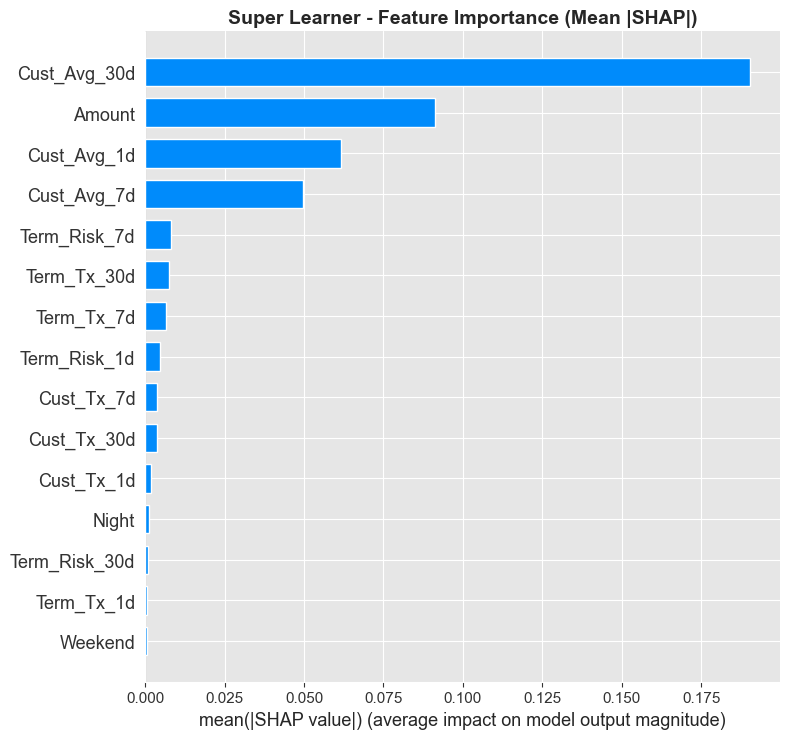

In [30]:
# Super Learner Feature Importance (Mean Absolute SHAP)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
shap.summary_plot(shap_values_sl, shap_sample_sl,
                  feature_names=short_feature_names,
                  plot_type="bar", show=False, max_display=15)
plt.title("Super Learner - Feature Importance (Mean |SHAP|)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## AUROC Comparison: Super Learner vs Base Learners

In [31]:
from sklearn.metrics import roc_curve, auc

# Use the same test set for fair comparison
X_test_roc = X_test_scaled_shap
y_test_roc = y_test_shap.values

# Get predictions from all base models
base_models_dict = preformance_results_tuning['fitted_base_models']
meta_model_roc = preformance_results_tuning['meta_model']

# Store predictions for each model
predictions = {}

# Base learner predictions
for model_name, model in base_models_dict.items():
    y_pred_proba = utils_training.get_predict_proba(model, X_test_roc)
    predictions[model_name] = y_pred_proba

# Super Learner predictions
# Generate meta-features from base models
meta_features_roc = []
for model in base_models_dict.values():
    pred = utils_training.get_predict_proba(model, X_test_roc)
    meta_features_roc.append(pred.reshape(-1, 1))
X_meta_roc = np.hstack(meta_features_roc)
predictions['Super Learner'] = meta_model_roc.predict_proba(X_meta_roc)[:, 1]

print(f"Generated predictions for {len(predictions)} models")
print(f"Test set size: {len(y_test_roc)}, Fraud rate: {y_test_roc.mean():.4f}")

Generated predictions for 8 models
Test set size: 57931, Fraud rate: 0.0061


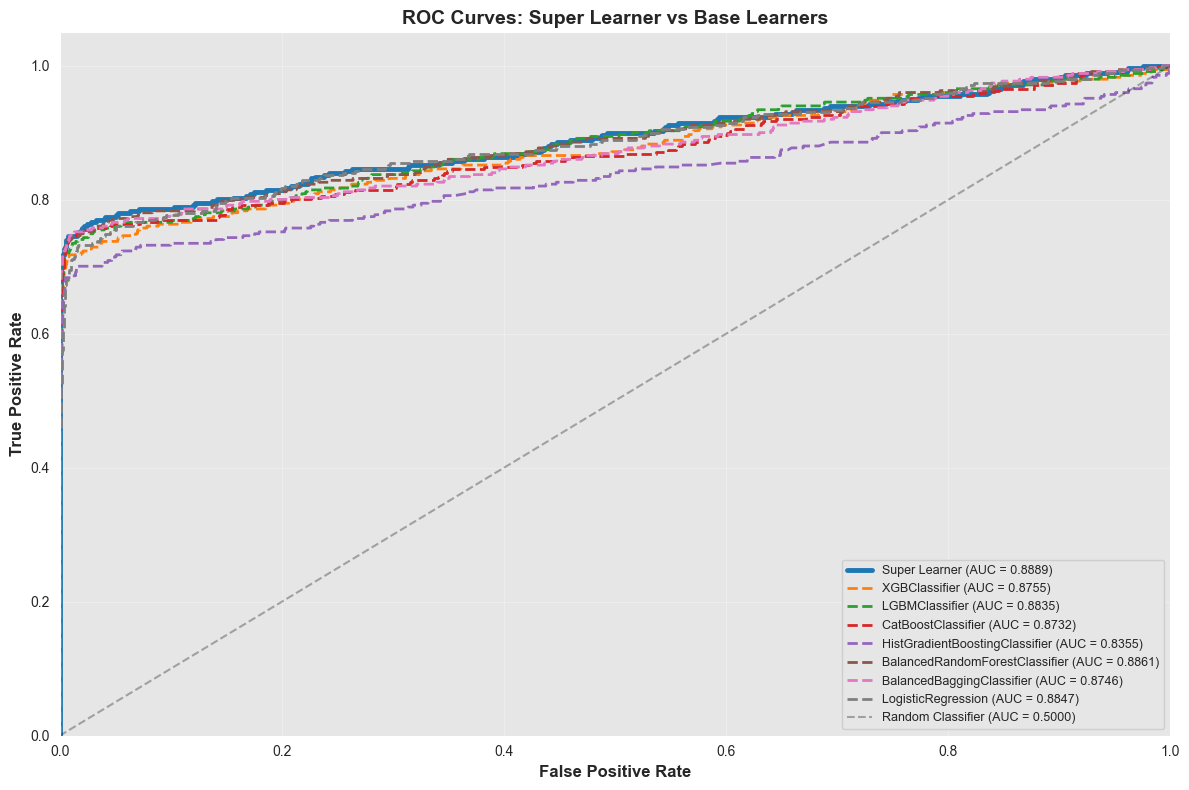

In [32]:
# Calculate ROC curves and AUC for all models
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Define color palette and line styles
colors = plt.cm.tab10(np.linspace(0, 1, 10))
model_order = ['Super Learner', 'XGBClassifier', 'LGBMClassifier', 'CatBoostClassifier',
               'HistGradientBoostingClassifier', 'BalancedRandomForestClassifier',
               'BalancedBaggingClassifier', 'LogisticRegression']

# Plot ROC curve for each model
for idx, model_name in enumerate(model_order):
    if model_name in predictions:
        y_pred = predictions[model_name]
        fpr, tpr, _ = roc_curve(y_test_roc, y_pred)
        roc_auc = auc(fpr, tpr)
        
        # Emphasize Super Learner with thicker line
        linewidth = 3.5 if model_name == 'Super Learner' else 2.0
        linestyle = '-' if model_name == 'Super Learner' else '--'
        
        ax.plot(fpr, tpr, color=colors[idx], lw=linewidth, linestyle=linestyle,
                label=f'{model_name} (AUC = {roc_auc:.4f})')

# Plot diagonal reference line
ax.plot([0, 1], [0, 1], 'k--', lw=1.5, alpha=0.3, label='Random Classifier (AUC = 0.5000)')

# Formatting
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('ROC Curves: Super Learner vs Base Learners', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=9, framealpha=0.9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Advanced Performance Analysis

### 1. Precision-Recall Curves (Critical for Imbalanced Data)

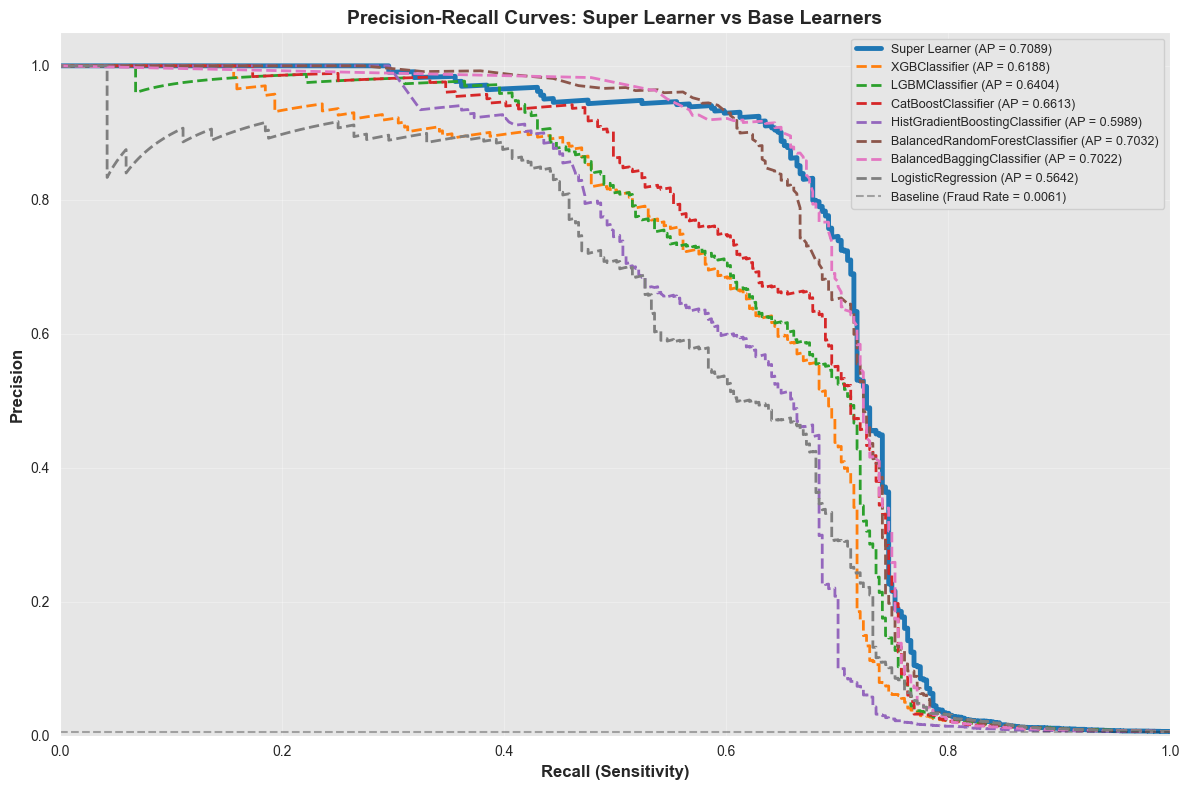


Note: PR curves are more informative than ROC for imbalanced datasets.
Fraud rate: 0.0061 (351/57931 transactions)


In [33]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Calculate Precision-Recall curves for all models
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

colors = plt.cm.tab10(np.linspace(0, 1, 10))
model_order = ['Super Learner', 'XGBClassifier', 'LGBMClassifier', 'CatBoostClassifier',
               'HistGradientBoostingClassifier', 'BalancedRandomForestClassifier',
               'BalancedBaggingClassifier', 'LogisticRegression']

# Plot PR curve for each model
for idx, model_name in enumerate(model_order):
    if model_name in predictions:
        y_pred = predictions[model_name]
        precision, recall, _ = precision_recall_curve(y_test_roc, y_pred)
        ap_score = average_precision_score(y_test_roc, y_pred)
        
        # Emphasize Super Learner with thicker line
        linewidth = 3.5 if model_name == 'Super Learner' else 2.0
        linestyle = '-' if model_name == 'Super Learner' else '--'
        
        ax.plot(recall, precision, color=colors[idx], lw=linewidth, linestyle=linestyle,
                label=f'{model_name} (AP = {ap_score:.4f})')

# Baseline: fraud rate
fraud_rate = y_test_roc.mean()
ax.axhline(y=fraud_rate, color='k', linestyle='--', lw=1.5, alpha=0.3, 
           label=f'Baseline (Fraud Rate = {fraud_rate:.4f})')

# Formatting
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Recall (Sensitivity)', fontsize=12, fontweight='bold')
ax.set_ylabel('Precision', fontsize=12, fontweight='bold')
ax.set_title('Precision-Recall Curves: Super Learner vs Base Learners', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=9, framealpha=0.9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nNote: PR curves are more informative than ROC for imbalanced datasets.")
print(f"Fraud rate: {fraud_rate:.4f} ({int(y_test_roc.sum())}/{len(y_test_roc)} transactions)")

### 2. Threshold Analysis: Precision, Recall, F1-Score Trade-offs

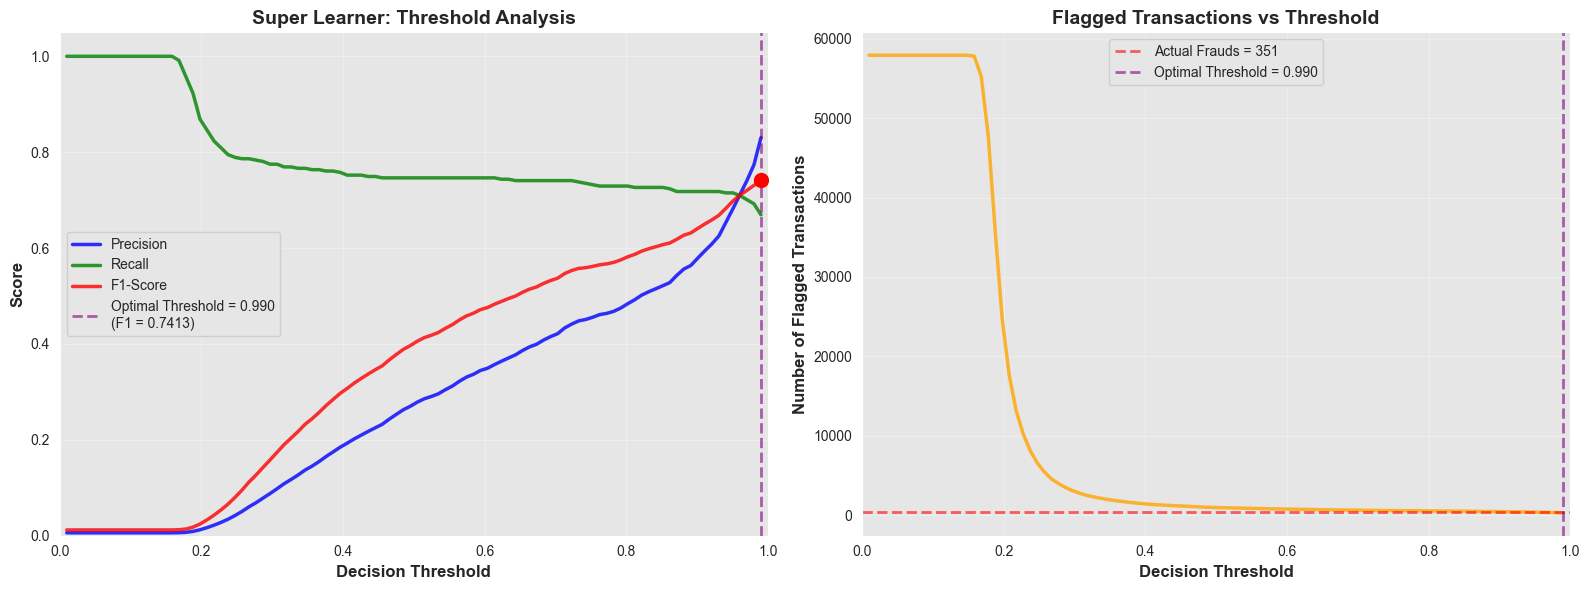


OPTIMAL THRESHOLD ANALYSIS (Super Learner)
Optimal Threshold: 0.9900
  - Precision:     0.8304
  - Recall:        0.6695
  - F1-Score:      0.7413
  - Flagged Txns:  283
  - Actual Frauds: 351


In [34]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Threshold analysis for Super Learner
y_pred_sl = predictions['Super Learner']
thresholds = np.linspace(0.01, 0.99, 100)

precisions = []
recalls = []
f1_scores = []
fraud_detected_counts = []

for thresh in thresholds:
    y_pred_binary = (y_pred_sl >= thresh).astype(int)
    
    # Handle edge cases where all predictions are 0 or 1
    if y_pred_binary.sum() == 0:  # No positive predictions
        precisions.append(0)
        recalls.append(0)
        f1_scores.append(0)
    else:
        precisions.append(precision_score(y_test_roc, y_pred_binary, zero_division=0))
        recalls.append(recall_score(y_test_roc, y_pred_binary, zero_division=0))
        f1_scores.append(f1_score(y_test_roc, y_pred_binary, zero_division=0))
    
    fraud_detected_counts.append(y_pred_binary.sum())

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Precision, Recall, F1-Score vs Threshold
ax1.plot(thresholds, precisions, 'b-', lw=2.5, label='Precision', alpha=0.8)
ax1.plot(thresholds, recalls, 'g-', lw=2.5, label='Recall', alpha=0.8)
ax1.plot(thresholds, f1_scores, 'r-', lw=2.5, label='F1-Score', alpha=0.8)

# Find optimal F1 threshold
optimal_idx = np.argmax(f1_scores)
optimal_thresh = thresholds[optimal_idx]
optimal_f1 = f1_scores[optimal_idx]

ax1.axvline(x=optimal_thresh, color='purple', linestyle='--', lw=2, alpha=0.6,
            label=f'Optimal Threshold = {optimal_thresh:.3f}\n(F1 = {optimal_f1:.4f})')
ax1.scatter([optimal_thresh], [optimal_f1], color='red', s=100, zorder=5)

ax1.set_xlabel('Decision Threshold', fontsize=12, fontweight='bold')
ax1.set_ylabel('Score', fontsize=12, fontweight='bold')
ax1.set_title('Super Learner: Threshold Analysis', fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=10, framealpha=0.9)
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1.05])

# Plot 2: Number of Flagged Transactions vs Threshold
ax2.plot(thresholds, fraud_detected_counts, 'orange', lw=2.5, alpha=0.8)
ax2.axhline(y=y_test_roc.sum(), color='red', linestyle='--', lw=2, alpha=0.6,
            label=f'Actual Frauds = {int(y_test_roc.sum())}')
ax2.axvline(x=optimal_thresh, color='purple', linestyle='--', lw=2, alpha=0.6,
            label=f'Optimal Threshold = {optimal_thresh:.3f}')

ax2.set_xlabel('Decision Threshold', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Flagged Transactions', fontsize=12, fontweight='bold')
ax2.set_title('Flagged Transactions vs Threshold', fontsize=14, fontweight='bold')
ax2.legend(loc='best', fontsize=10, framealpha=0.9)
ax2.grid(True, alpha=0.3)
ax2.set_xlim([0, 1])

plt.tight_layout()
plt.show()

# Print optimal threshold details
print(f"\n{'='*60}")
print(f"OPTIMAL THRESHOLD ANALYSIS (Super Learner)")
print(f"{'='*60}")
print(f"Optimal Threshold: {optimal_thresh:.4f}")
print(f"  - Precision:     {precisions[optimal_idx]:.4f}")
print(f"  - Recall:        {recalls[optimal_idx]:.4f}")
print(f"  - F1-Score:      {optimal_f1:.4f}")
print(f"  - Flagged Txns:  {fraud_detected_counts[optimal_idx]:,}")
print(f"  - Actual Frauds: {int(y_test_roc.sum()):,}")
print(f"{'='*60}")

### 3. Calibration Plot: Predicted Probability vs Actual Fraud Rate

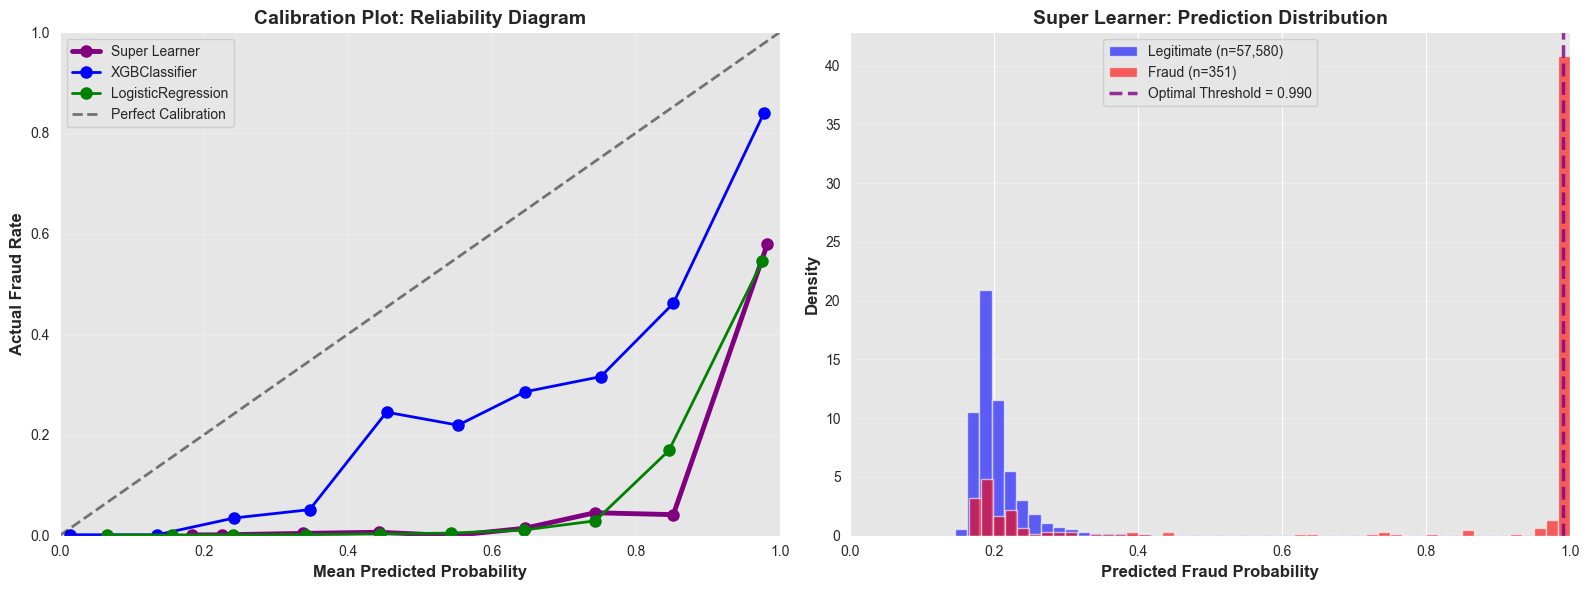


CALIBRATION ANALYSIS

Super Learner:
  - Mean Calibration Error: 0.4739
  - Mean Predicted Prob:     0.2148
  - Actual Fraud Rate:       0.0061

XGBClassifier:
  - Mean Calibration Error: 0.2516
  - Mean Predicted Prob:     0.0223
  - Actual Fraud Rate:       0.0061

LogisticRegression:
  - Mean Calibration Error: 0.4233
  - Mean Predicted Prob:     0.2265
  - Actual Fraud Rate:       0.0061

Note: Lower calibration error indicates better probability estimates.
Well-calibrated models have predicted probabilities that match actual frequencies.


In [35]:
from sklearn.calibration import calibration_curve

# Calibration analysis for top models
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Models to analyze
calibration_models = ['Super Learner', 'XGBClassifier', 'LogisticRegression']
colors_calib = ['purple', 'blue', 'green']

# Plot 1: Calibration Curves
ax1 = axes[0]
for model_name, color in zip(calibration_models, colors_calib):
    if model_name in predictions:
        y_pred = predictions[model_name]
        
        # Calculate calibration curve
        prob_true, prob_pred = calibration_curve(y_test_roc, y_pred, n_bins=10, strategy='uniform')
        
        linewidth = 3.5 if model_name == 'Super Learner' else 2.0
        ax1.plot(prob_pred, prob_true, marker='o', lw=linewidth, color=color,
                label=f'{model_name}', markersize=8)

# Perfect calibration line
ax1.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.5, label='Perfect Calibration')

ax1.set_xlabel('Mean Predicted Probability', fontsize=12, fontweight='bold')
ax1.set_ylabel('Actual Fraud Rate', fontsize=12, fontweight='bold')
ax1.set_title('Calibration Plot: Reliability Diagram', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left', fontsize=10, framealpha=0.9)
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])

# Plot 2: Prediction Distribution (Fraud vs Legitimate)
ax2 = axes[1]
y_pred_sl = predictions['Super Learner']

# Separate predictions by actual class
fraud_probs = y_pred_sl[y_test_roc == 1]
legit_probs = y_pred_sl[y_test_roc == 0]

# Plot histograms
ax2.hist(legit_probs, bins=50, alpha=0.6, color='blue', label=f'Legitimate (n={len(legit_probs):,})', density=True)
ax2.hist(fraud_probs, bins=50, alpha=0.6, color='red', label=f'Fraud (n={len(fraud_probs):,})', density=True)

# Add vertical line at optimal threshold
ax2.axvline(x=optimal_thresh, color='purple', linestyle='--', lw=2.5, alpha=0.8,
            label=f'Optimal Threshold = {optimal_thresh:.3f}')

ax2.set_xlabel('Predicted Fraud Probability', fontsize=12, fontweight='bold')
ax2.set_ylabel('Density', fontsize=12, fontweight='bold')
ax2.set_title('Super Learner: Prediction Distribution', fontsize=14, fontweight='bold')
ax2.legend(loc='upper center', fontsize=10, framealpha=0.9)
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_xlim([0, 1])

plt.tight_layout()
plt.show()

# Calculate calibration metrics
print(f"\n{'='*60}")
print(f"CALIBRATION ANALYSIS")
print(f"{'='*60}")

for model_name in calibration_models:
    if model_name in predictions:
        y_pred = predictions[model_name]
        prob_true, prob_pred = calibration_curve(y_test_roc, y_pred, n_bins=10, strategy='uniform')
        
        # Calculate calibration error (mean absolute difference)
        calib_error = np.mean(np.abs(prob_true - prob_pred))
        
        print(f"\n{model_name}:")
        print(f"  - Mean Calibration Error: {calib_error:.4f}")
        print(f"  - Mean Predicted Prob:     {y_pred.mean():.4f}")
        print(f"  - Actual Fraud Rate:       {y_test_roc.mean():.4f}")

print(f"\n{'='*60}")
print(f"Note: Lower calibration error indicates better probability estimates.")
print(f"Well-calibrated models have predicted probabilities that match actual frequencies.")
print(f"{'='*60}")

## Experiment: Adding MLP with Dropout to Super Learner

In [36]:
from sklearn.neural_network import MLPClassifier

# Define enhanced base models with MLP
def get_base_models_with_mlp():
    return {
        'XGBClassifier': XGBClassifier(
            learning_rate = 0.3,
            max_depth = 3,
            n_estimators = 100,
            n_jobs = -1,
            random_state = 0,
            scale_pos_weight = 10
        ),
        'LGBMClassifier': LGBMClassifier(
            learning_rate = 0.1,
            max_depth = 3,
            n_estimators = 100,
            n_jobs=-1,
            random_state=0,
            scale_pos_weight=1, 
            verbosity=-1
        ),
        'CatBoostClassifier': CatBoostClassifier(
            depth = 4,
            iterations = 500,
            learning_rate = 0.05,
            random_state = 0,
            scale_pos_weight = 5,
            verbose = 0
        ),
        'HistGradientBoostingClassifier': HistGradientBoostingClassifier(
            max_iter = 100,
            learning_rate = 0.05,
            max_depth = 5,
            random_state = 0,
            class_weight = 'balanced'
        ),
        'BalancedRandomForestClassifier': BalancedRandomForestClassifier(
            max_depth = 20,
            n_estimators = 100,
            n_jobs = -1,
            random_state = 0,
            sampling_strategy = 0.05
        ),
        'BalancedBaggingClassifier': BalancedBaggingClassifier(
            bootstrap = True,
            estimator = DecisionTreeClassifier(max_depth=20, random_state=0),
            n_estimators = 100,
            n_jobs = -1,
            random_state = 0,
            sampler = RandomUnderSampler(),
            sampling_strategy = 0.1
        ),
        'LogisticRegression': LogisticRegression(
            C=0.1,
            random_state=0,
            class_weight='balanced'
        ),
        'MLPClassifier': MLPClassifier(
            hidden_layer_sizes=(64, 32, 16),  # 3 hidden layers with decreasing neurons
            activation='relu',
            alpha=0.01,  # L2 regularization
            batch_size=128,
            learning_rate_init=0.001,
            max_iter=100,
            early_stopping=True,
            validation_fraction=0.1,
            random_state=0,
            verbose=False
        )
    }

print("Base models with MLP defined")
print(f"Total models: {len(get_base_models_with_mlp())}")

Base models with MLP defined
Total models: 8


In [37]:
# Train Super Learner with MLP included
base_models_with_mlp = get_base_models_with_mlp()

print("Training Super Learner with MLP...")
print("="*60)
preformance_results_mlp = run_super_learner(
    base_models_with_mlp, 
    transactions_df, 
    prequential_split_indices,
    input_features, 
    output_feature,
    transactions_df_scorer=transactions_df_scorer,
    verbose=True
)
print("="*60)
print("Training complete!")

Training Super Learner with MLP...
Training complete!
Training complete!


In [38]:
# Performance comparison: With MLP vs Without MLP
res_mlp = {}
res_mlp["SuperLearner"] = summarize_performance_across_folds(preformance_results_mlp['super_learner_performance'])
for name, performance_result in preformance_results_mlp['base_model_performance'].items():
    res_mlp[name] = summarize_performance_across_folds(performance_result)

print("\n" + "="*80)
print("PERFORMANCE WITH MLP ADDED TO SUPER LEARNER")
print("="*80)
df_mlp = pd.DataFrame.from_dict(res_mlp, orient='index')
display(df_mlp)

print("\n" + "="*80)
print("PERFORMANCE WITHOUT MLP (ORIGINAL)")
print("="*80)
res_original = {}
res_original["SuperLearner"] = summarize_performance_across_folds(preformance_results_tuning['super_learner_performance'])
for name, performance_result in preformance_results_tuning['base_model_performance'].items():
    res_original[name] = summarize_performance_across_folds(performance_result)
df_original = pd.DataFrame.from_dict(res_original, orient='index')
display(df_original)


PERFORMANCE WITH MLP ADDED TO SUPER LEARNER


,train_auc_mean,train_ap_mean,train_cp100_mean,test_auc_mean,test_ap_mean,test_cp100_mean
SuperLearner,0.9244,0.8003,0.4464,0.9081,0.7568,0.3204
XGBClassifier,0.9934,0.8701,0.4746,0.8798,0.6445,0.2864
LGBMClassifier,0.9660,0.8100,0.4379,0.8856,0.6535,0.2893
CatBoostClassifier,0.9710,0.8322,0.4454,0.8860,0.6721,0.2943
HistGradientBoostingClassifier,0.9724,0.7660,0.4354,0.8541,0.6004,0.2754
BalancedRandomForestClassifier,0.9991,0.9460,0.5189,0.8844,0.6673,0.2904
BalancedBaggingClassifier,0.9994,0.9489,0.5350,0.8804,0.6913,0.2929
LogisticRegression,0.8996,0.5940,0.3982,0.8704,0.5418,0.2825
MLPClassifier,0.9299,0.7653,0.4171,0.8782,0.6677,0.2861



PERFORMANCE WITHOUT MLP (ORIGINAL)


,train_auc_mean,train_ap_mean,train_cp100_mean,test_auc_mean,test_ap_mean,test_cp100_mean
SuperLearner,0.9244,0.7989,0.4475,0.9082,0.7538,0.3214
XGBClassifier,0.9934,0.8701,0.4746,0.8798,0.6445,0.2864
LGBMClassifier,0.9660,0.8100,0.4379,0.8856,0.6535,0.2893
CatBoostClassifier,0.9710,0.8322,0.4454,0.8860,0.6721,0.2943
HistGradientBoostingClassifier,0.9724,0.7660,0.4354,0.8541,0.6004,0.2754
BalancedRandomForestClassifier,0.9991,0.9460,0.5189,0.8844,0.6673,0.2904
BalancedBaggingClassifier,0.9994,0.9489,0.5350,0.8804,0.6913,0.2929
LogisticRegression,0.8996,0.5940,0.3982,0.8704,0.5418,0.2825


### AUROC Comparison: SuperLearner With vs Without MLP

In [39]:
# Extract AUROC scores for comparison
def extract_auroc_from_results(performance_results):
    """Extract train and test AUROC across folds"""
    train_aucs = []
    test_aucs = []
    
    for fold_result in performance_results['super_learner_performance']:
        train_aucs.append(fold_result['results']['train']['auc'])
        test_aucs.append(fold_result['results']['test']['auc'])
    
    return {
        'train_mean': np.mean(train_aucs),
        'train_std': np.std(train_aucs),
        'test_mean': np.mean(test_aucs),
        'test_std': np.std(test_aucs),
        'train_aucs': train_aucs,
        'test_aucs': test_aucs
    }

# Compare AUROC
auroc_original = extract_auroc_from_results(preformance_results_tuning)
auroc_with_mlp = extract_auroc_from_results(preformance_results_mlp)

print("\n" + "="*80)
print("SUPER LEARNER AUROC COMPARISON")
print("="*80)
print(f"\nORIGINAL (7 base learners):")
print(f"  Train AUROC: {auroc_original['train_mean']:.4f} ± {auroc_original['train_std']:.4f}")
print(f"  Test AUROC:  {auroc_original['test_mean']:.4f} ± {auroc_original['test_std']:.4f}")

print(f"\nWITH MLP (8 base learners):")
print(f"  Train AUROC: {auroc_with_mlp['train_mean']:.4f} ± {auroc_with_mlp['train_std']:.4f}")
print(f"  Test AUROC:  {auroc_with_mlp['test_mean']:.4f} ± {auroc_with_mlp['test_std']:.4f}")

print(f"\nIMPROVEMENT:")
train_improvement = auroc_with_mlp['train_mean'] - auroc_original['train_mean']
test_improvement = auroc_with_mlp['test_mean'] - auroc_original['test_mean']
print(f"  Train: {train_improvement:+.4f} ({train_improvement*100:+.2f}%)")
print(f"  Test:  {test_improvement:+.4f} ({test_improvement*100:+.2f}%)")

if test_improvement > 0:
    print(f"\n✅ MLP IMPROVED Super Learner test AUROC by {test_improvement:.4f}")
else:
    print(f"\n❌ MLP DECREASED Super Learner test AUROC by {abs(test_improvement):.4f}")
print("="*80)


SUPER LEARNER AUROC COMPARISON

ORIGINAL (7 base learners):
  Train AUROC: 0.9244 ± 0.0433
  Test AUROC:  0.9082 ± 0.0530

WITH MLP (8 base learners):
  Train AUROC: 0.9244 ± 0.0433
  Test AUROC:  0.9081 ± 0.0530

IMPROVEMENT:
  Train: +0.0000 (+0.00%)
  Test:  -0.0001 (-0.01%)

❌ MLP DECREASED Super Learner test AUROC by 0.0001


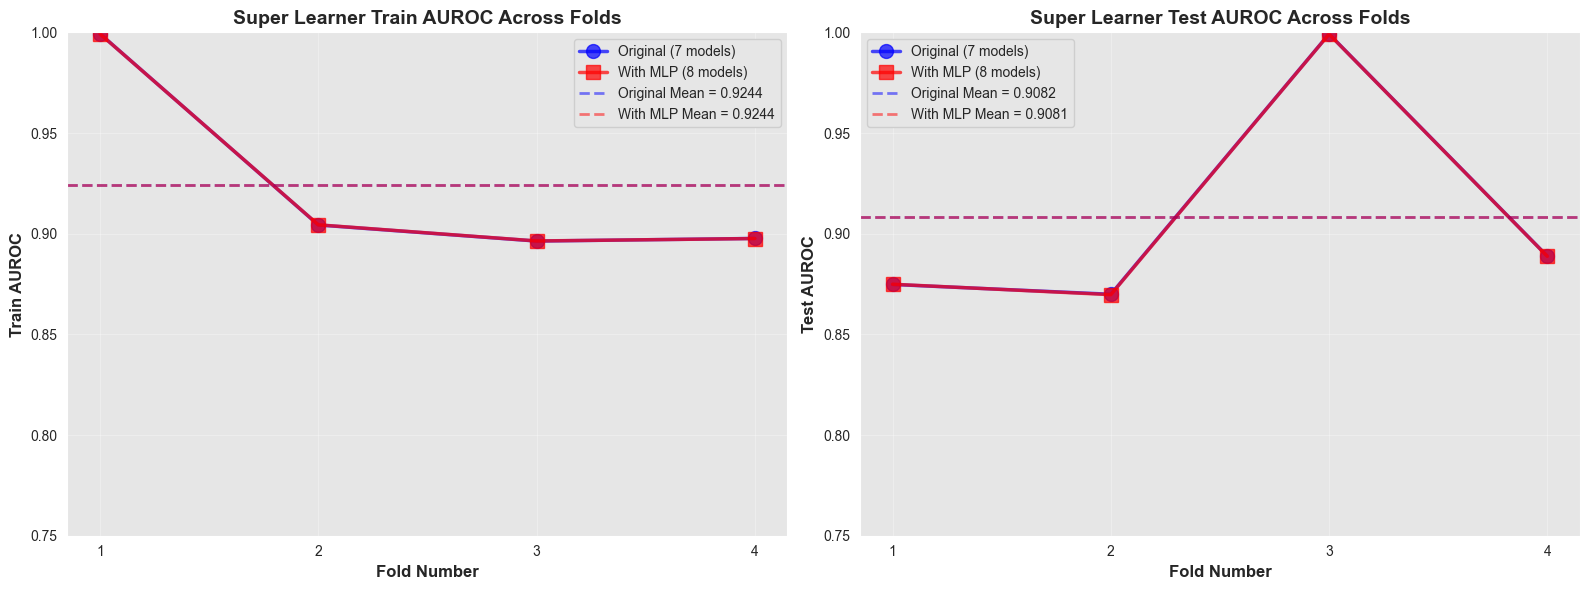

In [40]:
# Visualize AUROC comparison across folds
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Fold indices
folds = np.arange(1, len(auroc_original['train_aucs']) + 1)

# Plot 1: Train AUROC across folds
ax1 = axes[0]
ax1.plot(folds, auroc_original['train_aucs'], 'o-', color='blue', lw=2.5, 
         markersize=10, label='Original (7 models)', alpha=0.7)
ax1.plot(folds, auroc_with_mlp['train_aucs'], 's-', color='red', lw=2.5, 
         markersize=10, label='With MLP (8 models)', alpha=0.7)

# Add mean lines
ax1.axhline(y=auroc_original['train_mean'], color='blue', linestyle='--', lw=2, alpha=0.5,
            label=f"Original Mean = {auroc_original['train_mean']:.4f}")
ax1.axhline(y=auroc_with_mlp['train_mean'], color='red', linestyle='--', lw=2, alpha=0.5,
            label=f"With MLP Mean = {auroc_with_mlp['train_mean']:.4f}")

ax1.set_xlabel('Fold Number', fontsize=12, fontweight='bold')
ax1.set_ylabel('Train AUROC', fontsize=12, fontweight='bold')
ax1.set_title('Super Learner Train AUROC Across Folds', fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=10, framealpha=0.9)
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0.75, 1.0])
ax1.set_xticks(folds)

# Plot 2: Test AUROC across folds
ax2 = axes[1]
ax2.plot(folds, auroc_original['test_aucs'], 'o-', color='blue', lw=2.5, 
         markersize=10, label='Original (7 models)', alpha=0.7)
ax2.plot(folds, auroc_with_mlp['test_aucs'], 's-', color='red', lw=2.5, 
         markersize=10, label='With MLP (8 models)', alpha=0.7)

# Add mean lines
ax2.axhline(y=auroc_original['test_mean'], color='blue', linestyle='--', lw=2, alpha=0.5,
            label=f"Original Mean = {auroc_original['test_mean']:.4f}")
ax2.axhline(y=auroc_with_mlp['test_mean'], color='red', linestyle='--', lw=2, alpha=0.5,
            label=f"With MLP Mean = {auroc_with_mlp['test_mean']:.4f}")

ax2.set_xlabel('Fold Number', fontsize=12, fontweight='bold')
ax2.set_ylabel('Test AUROC', fontsize=12, fontweight='bold')
ax2.set_title('Super Learner Test AUROC Across Folds', fontsize=14, fontweight='bold')
ax2.legend(loc='best', fontsize=10, framealpha=0.9)
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0.75, 1.0])
ax2.set_xticks(folds)

plt.tight_layout()
plt.show()

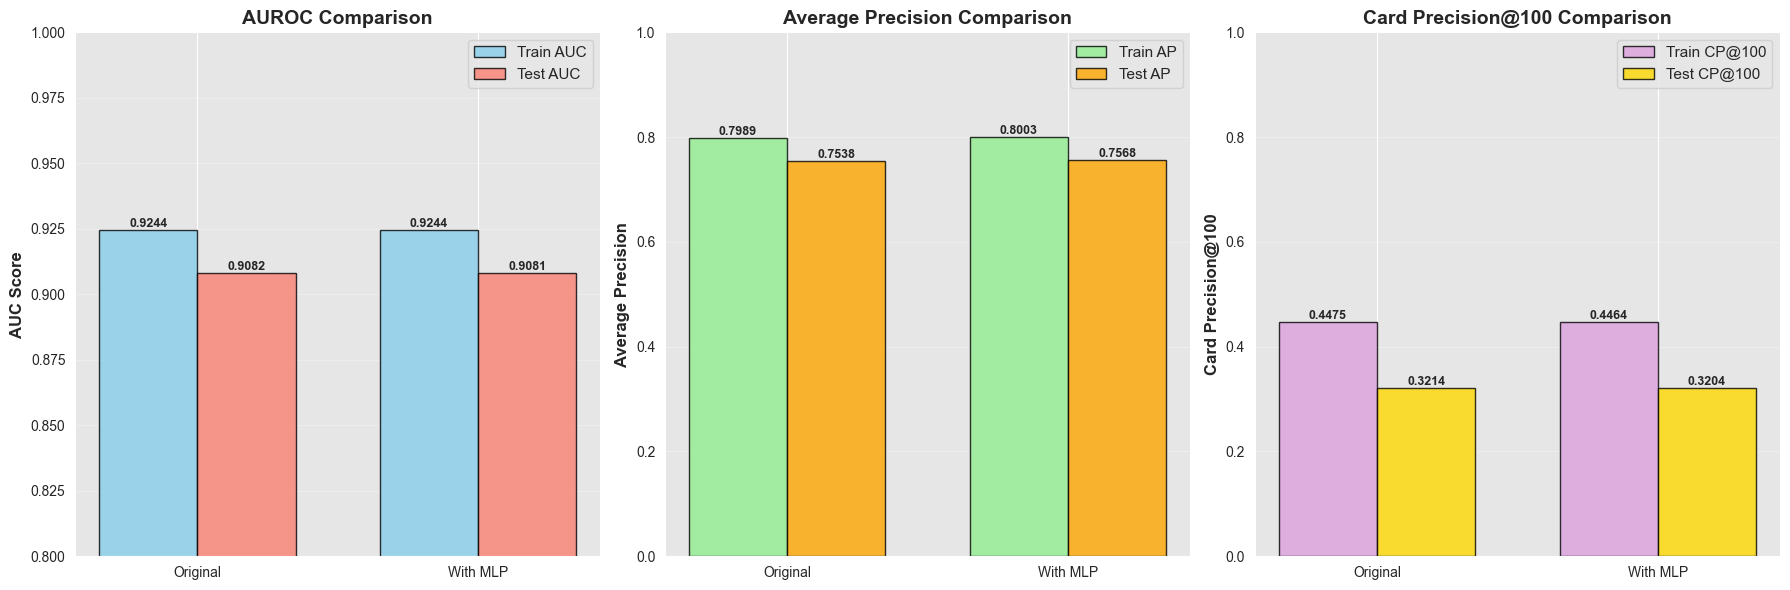


SUMMARY TABLE: Super Learner Performance Comparison


,Train AUC,Test AUC,Train AP,Test AP,Train CP100,Test CP100
Model,,,,,,
Original,0.924385,0.908184,0.7989,0.7538,0.4475,0.3214
With MLP,0.924392,0.908127,0.8003,0.7568,0.4464,0.3204


In [41]:
# Statistical comparison: Bar chart of all metrics
metrics_comparison = {
    'Model': ['Original', 'With MLP'],
    'Train AUC': [auroc_original['train_mean'], auroc_with_mlp['train_mean']],
    'Test AUC': [auroc_original['test_mean'], auroc_with_mlp['test_mean']],
    'Train AP': [float(res_original['SuperLearner']['train_ap_mean']), 
                 float(res_mlp['SuperLearner']['train_ap_mean'])],
    'Test AP': [float(res_original['SuperLearner']['test_ap_mean']), 
                float(res_mlp['SuperLearner']['test_ap_mean'])],
    'Train CP100': [float(res_original['SuperLearner']['train_cp100_mean']), 
                    float(res_mlp['SuperLearner']['train_cp100_mean'])],
    'Test CP100': [float(res_original['SuperLearner']['test_cp100_mean']), 
                   float(res_mlp['SuperLearner']['test_cp100_mean'])]
}

df_comparison = pd.DataFrame(metrics_comparison)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: AUC comparison
x = np.arange(len(df_comparison['Model']))
width = 0.35

ax1 = axes[0]
bars1 = ax1.bar(x - width/2, df_comparison['Train AUC'], width, label='Train AUC', 
                color='skyblue', alpha=0.8, edgecolor='black')
bars2 = ax1.bar(x + width/2, df_comparison['Test AUC'], width, label='Test AUC', 
                color='salmon', alpha=0.8, edgecolor='black')

ax1.set_ylabel('AUC Score', fontsize=12, fontweight='bold')
ax1.set_title('AUROC Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(df_comparison['Model'])
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim([0.8, 1.0])

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot 2: Average Precision comparison
ax2 = axes[1]
bars3 = ax2.bar(x - width/2, df_comparison['Train AP'], width, label='Train AP', 
                color='lightgreen', alpha=0.8, edgecolor='black')
bars4 = ax2.bar(x + width/2, df_comparison['Test AP'], width, label='Test AP', 
                color='orange', alpha=0.8, edgecolor='black')

ax2.set_ylabel('Average Precision', fontsize=12, fontweight='bold')
ax2.set_title('Average Precision Comparison', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(df_comparison['Model'])
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_ylim([0.0, 1.0])

for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot 3: Card Precision@100 comparison
ax3 = axes[2]
bars5 = ax3.bar(x - width/2, df_comparison['Train CP100'], width, label='Train CP@100', 
                color='plum', alpha=0.8, edgecolor='black')
bars6 = ax3.bar(x + width/2, df_comparison['Test CP100'], width, label='Test CP@100', 
                color='gold', alpha=0.8, edgecolor='black')

ax3.set_ylabel('Card Precision@100', fontsize=12, fontweight='bold')
ax3.set_title('Card Precision@100 Comparison', fontsize=14, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(df_comparison['Model'])
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3, axis='y')
ax3.set_ylim([0.0, 1.0])

for bars in [bars5, bars6]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("SUMMARY TABLE: Super Learner Performance Comparison")
print("="*80)
display(df_comparison.set_index('Model'))

## Experiment: Isolation Forest as Feature Engineering

In [42]:
from sklearn.ensemble import IsolationForest

# Modified function to include Isolation Forest feature engineering
def get_out_of_fold_predictions_with_isolation_forest(transactions_df, prequential_split_indices, base_models_dict,
                                                       input_features, output_feature, transactions_df_scorer=None):
    """
    Out-of-fold predictions with Isolation Forest anomaly score as an additional feature
    """
    meta_rows = []
    meta_labels = []
    meta_indices = []
    model_names = list(base_models_dict.keys())

    # iterate prequential folds
    for fold_i, (train_ix, test_ix) in enumerate(prequential_split_indices):
        print(f"Processing Fold {fold_i + 1}/4 with Isolation Forest feature...")
        
        # get train/test slices
        train_df = transactions_df.iloc[train_ix]
        test_df = transactions_df.iloc[test_ix]
        X_train, y_train, X_test, y_test = get_train_test_features(train_df, test_df, input_features, output_feature)

        # Scale original features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Train Isolation Forest on scaled training data
        iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=0, n_jobs=-1)
        iso_forest.fit(X_train_scaled)
        
        # Generate anomaly scores (negative of score_samples for interpretability)
        train_anomaly_scores = -iso_forest.score_samples(X_train_scaled)
        test_anomaly_scores = -iso_forest.score_samples(X_test_scaled)
        
        # Add anomaly score as new feature
        X_train_with_anomaly = np.column_stack([X_train_scaled, train_anomaly_scores])
        X_test_with_anomaly = np.column_stack([X_test_scaled, test_anomaly_scores])

        # Collect base model predictions with enhanced features
        fold_preds = []
        for name in model_names:
            model = clone(base_models_dict[name])
            model.fit(X_train_with_anomaly, y_train)
            probs = utils_training.get_predict_proba(model, X_test_with_anomaly)
            fold_preds.append(probs.reshape(-1, 1))

        # Stack column-wise to shape (n_test_rows, n_models)
        fold_meta_X = np.hstack(fold_preds)

        meta_rows.append(fold_meta_X)
        meta_labels.append(y_test)
        meta_indices.append(test_df.index)

    # Vertically stack folds
    meta_X = np.vstack(meta_rows)
    meta_y = np.concatenate(meta_labels)
    meta_index = np.concatenate([np.array(idx) for idx in meta_indices])

    return meta_X, meta_y, meta_index, model_names


def fit_base_models_full_with_isolation_forest(X_train_df, y_train_series, base_models_dict):
    """
    Fit base models on full training data with Isolation Forest feature
    """
    fitted_models = {}
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_df.values)
    
    # Train Isolation Forest
    iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=0, n_jobs=-1)
    iso_forest.fit(X_train_scaled)
    
    # Add anomaly score
    train_anomaly_scores = -iso_forest.score_samples(X_train_scaled)
    X_train_with_anomaly = np.column_stack([X_train_scaled, train_anomaly_scores])
    
    # Fit models
    for name, model in base_models_dict.items():
        m = clone(model)
        m.fit(X_train_with_anomaly, y_train_series.values)
        fitted_models[name] = m
    
    return fitted_models, scaler, iso_forest


def evaluate_base_models_per_fold_with_isolation_forest(base_models_dict, train_df, test_df,
                                                          input_features, output_feature,
                                                          transactions_df_scorer=None):
    """
    Evaluate base models per fold with Isolation Forest feature
    """
    X_train, y_train, X_test, y_test = get_train_test_features(train_df, test_df, input_features, output_feature)

    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Isolation Forest
    iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=0, n_jobs=-1)
    iso_forest.fit(X_train_scaled)
    
    train_anomaly_scores = -iso_forest.score_samples(X_train_scaled)
    test_anomaly_scores = -iso_forest.score_samples(X_test_scaled)
    
    X_train_with_anomaly = np.column_stack([X_train_scaled, train_anomaly_scores])
    X_test_with_anomaly = np.column_stack([X_test_scaled, test_anomaly_scores])

    fold_results = {}
    for name, model in base_models_dict.items():
        m = clone(model)
        m.fit(X_train_with_anomaly, y_train)

        train_probs = utils_training.get_predict_proba(m, X_train_with_anomaly)
        test_probs = utils_training.get_predict_proba(m, X_test_with_anomaly)
        
        train_auc, train_ap, train_cp = get_performance_metrics(train_df, y_train, train_probs, transactions_df_scorer)
        test_auc, test_ap, test_cp = get_performance_metrics(test_df, y_test, test_probs, transactions_df_scorer)

        train_performance_detail = {'n_train': len(train_df), 'auc': train_auc, 'ap': train_ap, 'cp100': train_cp}
        test_performance_detail = {'n_train': len(test_df), 'auc': test_auc, 'ap': test_ap, 'cp100': test_cp}
        fold_results[name] = {'train': train_performance_detail, 'test': test_performance_detail}

    return fold_results


def evaluate_super_learner_per_fold_with_isolation_forest(fitted_base_models, meta_model,
                                                            train_df, test_df,
                                                            input_features, output_feature,
                                                            scaler, iso_forest, transactions_df_scorer=None):
    """
    Evaluate super learner per fold with Isolation Forest feature
    """
    X_train, y_train, X_test, y_test = get_train_test_features(train_df, test_df, input_features, output_feature)

    # Scale
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Add Isolation Forest scores
    train_anomaly_scores = -iso_forest.score_samples(X_train_scaled)
    test_anomaly_scores = -iso_forest.score_samples(X_test_scaled)
    
    X_train_with_anomaly = np.column_stack([X_train_scaled, train_anomaly_scores])
    X_test_with_anomaly = np.column_stack([X_test_scaled, test_anomaly_scores])

    # Build meta features
    train_meta = []
    for m in fitted_base_models.values():
        train_probs = utils_training.get_predict_proba(m, X_train_with_anomaly)
        train_meta.append(train_probs.reshape(-1, 1))
    X_train_meta = np.hstack(train_meta)

    test_meta = []
    for m in fitted_base_models.values():
        test_probs = utils_training.get_predict_proba(m, X_test_with_anomaly)
        test_meta.append(test_probs.reshape(-1, 1))
    X_test_meta = np.hstack(test_meta)

    # Predict
    train_probs = meta_model.predict_proba(X_train_meta)[:, 1]
    test_probs = meta_model.predict_proba(X_test_meta)[:, 1]
    
    train_auc, train_ap, train_cp = get_performance_metrics(train_df, y_train, train_probs, transactions_df_scorer)
    test_auc, test_ap, test_cp = get_performance_metrics(test_df, y_test, test_probs, transactions_df_scorer)

    train_performance_detail = {'n_train': len(train_df), 'auc': train_auc, 'ap': train_ap, 'cp100': train_cp}
    test_performance_detail = {'n_train': len(test_df), 'auc': test_auc, 'ap': test_ap, 'cp100': test_cp}
    return {'train': train_performance_detail, 'test': test_performance_detail}


def run_super_learner_with_isolation_forest(base_models, transactions_df, prequential_split_indices,
                                             input_features, output_feature,
                                             transactions_df_scorer=None, verbose=True):
    """
    Full pipeline with Isolation Forest feature engineering
    """
    # OOF meta features with Isolation Forest
    meta_X, meta_y, meta_index, model_names = get_out_of_fold_predictions_with_isolation_forest(
        transactions_df, prequential_split_indices, base_models,
        input_features, output_feature, transactions_df_scorer
    )
    meta_model = fit_meta_model(base_models, meta_X, meta_y)

    # Fit base models on first window with Isolation Forest
    first_train_ix, _ = prequential_split_indices[0]
    train_df_full = transactions_df.iloc[first_train_ix]
    X_train_full = train_df_full[input_features]
    y_train_full = train_df_full[output_feature]

    fitted_base_models, global_scaler, global_iso_forest = fit_base_models_full_with_isolation_forest(
        X_train_full, y_train_full, base_models
    )

    # Evaluate per fold with Isolation Forest
    super_learner_performance = []
    base_model_performance = {name: [] for name in base_models.keys()}

    for fold_i, (train_ix, test_ix) in enumerate(prequential_split_indices):
        train_df = transactions_df.iloc[train_ix]
        test_df = transactions_df.iloc[test_ix]

        base_fold_result = evaluate_base_models_per_fold_with_isolation_forest(
            base_models, train_df, test_df,
            input_features, output_feature,
            transactions_df_scorer
        )
        for model_name, metrics in base_fold_result.items():
            base_model_performance[model_name].append({'fold': fold_i, 'results': metrics})

        super_learner_fold_result = evaluate_super_learner_per_fold_with_isolation_forest(
            fitted_base_models, meta_model,
            train_df, test_df,
            input_features, output_feature,
            global_scaler, global_iso_forest, transactions_df_scorer
        )
        super_learner_performance.append({'fold': fold_i, 'results': super_learner_fold_result})

    return {
        'meta_model': meta_model,
        'fitted_base_models': fitted_base_models,
        'global_scaler': global_scaler,
        'isolation_forest': global_iso_forest,
        'base_model_performance': base_model_performance,
        'super_learner_performance': super_learner_performance
    }

print("Isolation Forest feature engineering functions defined!")

Isolation Forest feature engineering functions defined!


In [43]:
# Train Super Learner with Isolation Forest feature engineering
# Using original 7 base models (without MLP)
base_models_original = get_base_models_tuning()

print("Training Super Learner with Isolation Forest feature engineering...")
print("="*80)
print("Note: Adding ANOMALY_SCORE as 16th feature to all base models")
print("="*80)

preformance_results_iso_forest = run_super_learner_with_isolation_forest(
    base_models_original, 
    transactions_df, 
    prequential_split_indices,
    input_features, 
    output_feature,
    transactions_df_scorer=transactions_df_scorer,
    verbose=True
)

print("="*80)
print("Training complete with Isolation Forest feature!")

Training Super Learner with Isolation Forest feature engineering...
Note: Adding ANOMALY_SCORE as 16th feature to all base models
Processing Fold 1/4 with Isolation Forest feature...
Processing Fold 2/4 with Isolation Forest feature...
Processing Fold 2/4 with Isolation Forest feature...
Processing Fold 3/4 with Isolation Forest feature...
Processing Fold 3/4 with Isolation Forest feature...
Processing Fold 4/4 with Isolation Forest feature...
Processing Fold 4/4 with Isolation Forest feature...
Training complete with Isolation Forest feature!
Training complete with Isolation Forest feature!


In [44]:
# Performance comparison: With vs Without Isolation Forest feature
res_iso_forest = {}
res_iso_forest["SuperLearner"] = summarize_performance_across_folds(preformance_results_iso_forest['super_learner_performance'])
for name, performance_result in preformance_results_iso_forest['base_model_performance'].items():
    res_iso_forest[name] = summarize_performance_across_folds(performance_result)

print("\n" + "="*80)
print("PERFORMANCE WITH ISOLATION FOREST FEATURE (16 features)")
print("="*80)
df_iso_forest = pd.DataFrame.from_dict(res_iso_forest, orient='index')
display(df_iso_forest)

print("\n" + "="*80)
print("PERFORMANCE WITHOUT ISOLATION FOREST (15 features - ORIGINAL)")
print("="*80)
df_original = pd.DataFrame.from_dict(res_original, orient='index')
display(df_original)


PERFORMANCE WITH ISOLATION FOREST FEATURE (16 features)


,train_auc_mean,train_ap_mean,train_cp100_mean,test_auc_mean,test_ap_mean,test_cp100_mean
SuperLearner,0.9249,0.7942,0.4457,0.9098,0.7486,0.3200
XGBClassifier,0.9951,0.8733,0.4836,0.8806,0.6409,0.2861
LGBMClassifier,0.9723,0.8150,0.4414,0.8853,0.6497,0.2907
CatBoostClassifier,0.9735,0.8364,0.4489,0.8837,0.6706,0.2925
HistGradientBoostingClassifier,0.9720,0.7592,0.4343,0.8675,0.5997,0.2811
BalancedRandomForestClassifier,0.9991,0.9466,0.5207,0.8831,0.6750,0.2911
BalancedBaggingClassifier,0.9993,0.9461,0.5350,0.8823,0.6921,0.2911
LogisticRegression,0.8998,0.5940,0.3971,0.8703,0.5421,0.2821



PERFORMANCE WITHOUT ISOLATION FOREST (15 features - ORIGINAL)


,train_auc_mean,train_ap_mean,train_cp100_mean,test_auc_mean,test_ap_mean,test_cp100_mean
SuperLearner,0.9244,0.7989,0.4475,0.9082,0.7538,0.3214
XGBClassifier,0.9934,0.8701,0.4746,0.8798,0.6445,0.2864
LGBMClassifier,0.9660,0.8100,0.4379,0.8856,0.6535,0.2893
CatBoostClassifier,0.9710,0.8322,0.4454,0.8860,0.6721,0.2943
HistGradientBoostingClassifier,0.9724,0.7660,0.4354,0.8541,0.6004,0.2754
BalancedRandomForestClassifier,0.9991,0.9460,0.5189,0.8844,0.6673,0.2904
BalancedBaggingClassifier,0.9994,0.9489,0.5350,0.8804,0.6913,0.2929
LogisticRegression,0.8996,0.5940,0.3982,0.8704,0.5418,0.2825


### AUROC Comparison: With vs Without Isolation Forest Feature

In [45]:
# Extract AUROC scores for Isolation Forest comparison
auroc_iso_forest = extract_auroc_from_results(preformance_results_iso_forest)

print("\n" + "="*80)
print("SUPER LEARNER AUROC COMPARISON: Isolation Forest Feature Engineering")
print("="*80)
print(f"\nORIGINAL (15 features):")
print(f"  Train AUROC: {auroc_original['train_mean']:.4f} ± {auroc_original['train_std']:.4f}")
print(f"  Test AUROC:  {auroc_original['test_mean']:.4f} ± {auroc_original['test_std']:.4f}")

print(f"\nWITH ISOLATION FOREST FEATURE (16 features):")
print(f"  Train AUROC: {auroc_iso_forest['train_mean']:.4f} ± {auroc_iso_forest['train_std']:.4f}")
print(f"  Test AUROC:  {auroc_iso_forest['test_mean']:.4f} ± {auroc_iso_forest['test_std']:.4f}")

print(f"\nIMPROVEMENT:")
train_improvement_iso = auroc_iso_forest['train_mean'] - auroc_original['train_mean']
test_improvement_iso = auroc_iso_forest['test_mean'] - auroc_original['test_mean']
print(f"  Train: {train_improvement_iso:+.4f} ({train_improvement_iso*100:+.2f}%)")
print(f"  Test:  {test_improvement_iso:+.4f} ({test_improvement_iso*100:+.2f}%)")

if test_improvement_iso > 0:
    print(f"\n✅ ISOLATION FOREST FEATURE IMPROVED Super Learner test AUROC by {test_improvement_iso:.4f}")
else:
    print(f"\n❌ ISOLATION FOREST FEATURE DECREASED Super Learner test AUROC by {abs(test_improvement_iso):.4f}")
print("="*80)


SUPER LEARNER AUROC COMPARISON: Isolation Forest Feature Engineering

ORIGINAL (15 features):
  Train AUROC: 0.9244 ± 0.0433
  Test AUROC:  0.9082 ± 0.0530

WITH ISOLATION FOREST FEATURE (16 features):
  Train AUROC: 0.9249 ± 0.0430
  Test AUROC:  0.9098 ± 0.0520

IMPROVEMENT:
  Train: +0.0005 (+0.05%)
  Test:  +0.0016 (+0.16%)

✅ ISOLATION FOREST FEATURE IMPROVED Super Learner test AUROC by 0.0016


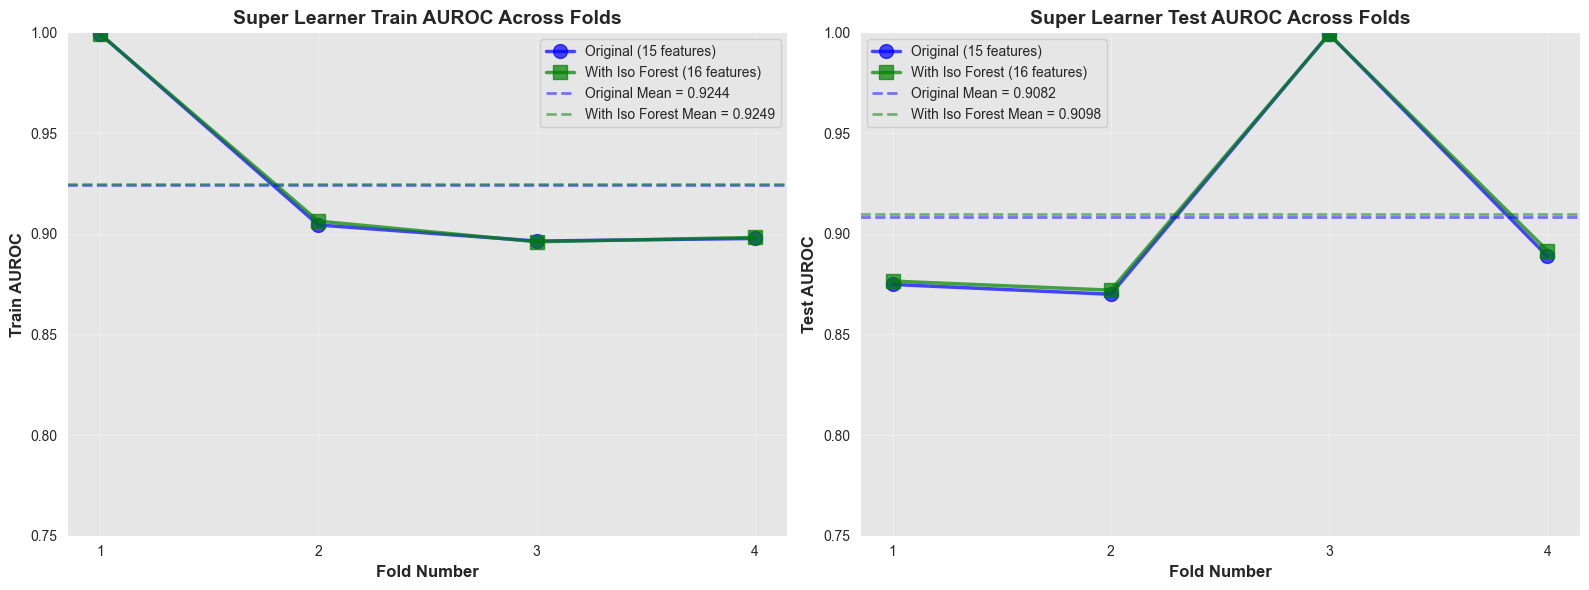

In [46]:
# Visualize AUROC comparison across folds
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

folds = np.arange(1, len(auroc_original['train_aucs']) + 1)

# Plot 1: Train AUROC
ax1 = axes[0]
ax1.plot(folds, auroc_original['train_aucs'], 'o-', color='blue', lw=2.5, 
         markersize=10, label='Original (15 features)', alpha=0.7)
ax1.plot(folds, auroc_iso_forest['train_aucs'], 's-', color='green', lw=2.5, 
         markersize=10, label='With Iso Forest (16 features)', alpha=0.7)

ax1.axhline(y=auroc_original['train_mean'], color='blue', linestyle='--', lw=2, alpha=0.5,
            label=f"Original Mean = {auroc_original['train_mean']:.4f}")
ax1.axhline(y=auroc_iso_forest['train_mean'], color='green', linestyle='--', lw=2, alpha=0.5,
            label=f"With Iso Forest Mean = {auroc_iso_forest['train_mean']:.4f}")

ax1.set_xlabel('Fold Number', fontsize=12, fontweight='bold')
ax1.set_ylabel('Train AUROC', fontsize=12, fontweight='bold')
ax1.set_title('Super Learner Train AUROC Across Folds', fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=10, framealpha=0.9)
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0.75, 1.0])
ax1.set_xticks(folds)

# Plot 2: Test AUROC
ax2 = axes[1]
ax2.plot(folds, auroc_original['test_aucs'], 'o-', color='blue', lw=2.5, 
         markersize=10, label='Original (15 features)', alpha=0.7)
ax2.plot(folds, auroc_iso_forest['test_aucs'], 's-', color='green', lw=2.5, 
         markersize=10, label='With Iso Forest (16 features)', alpha=0.7)

ax2.axhline(y=auroc_original['test_mean'], color='blue', linestyle='--', lw=2, alpha=0.5,
            label=f"Original Mean = {auroc_original['test_mean']:.4f}")
ax2.axhline(y=auroc_iso_forest['test_mean'], color='green', linestyle='--', lw=2, alpha=0.5,
            label=f"With Iso Forest Mean = {auroc_iso_forest['test_mean']:.4f}")

ax2.set_xlabel('Fold Number', fontsize=12, fontweight='bold')
ax2.set_ylabel('Test AUROC', fontsize=12, fontweight='bold')
ax2.set_title('Super Learner Test AUROC Across Folds', fontsize=14, fontweight='bold')
ax2.legend(loc='best', fontsize=10, framealpha=0.9)
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0.75, 1.0])
ax2.set_xticks(folds)

plt.tight_layout()
plt.show()

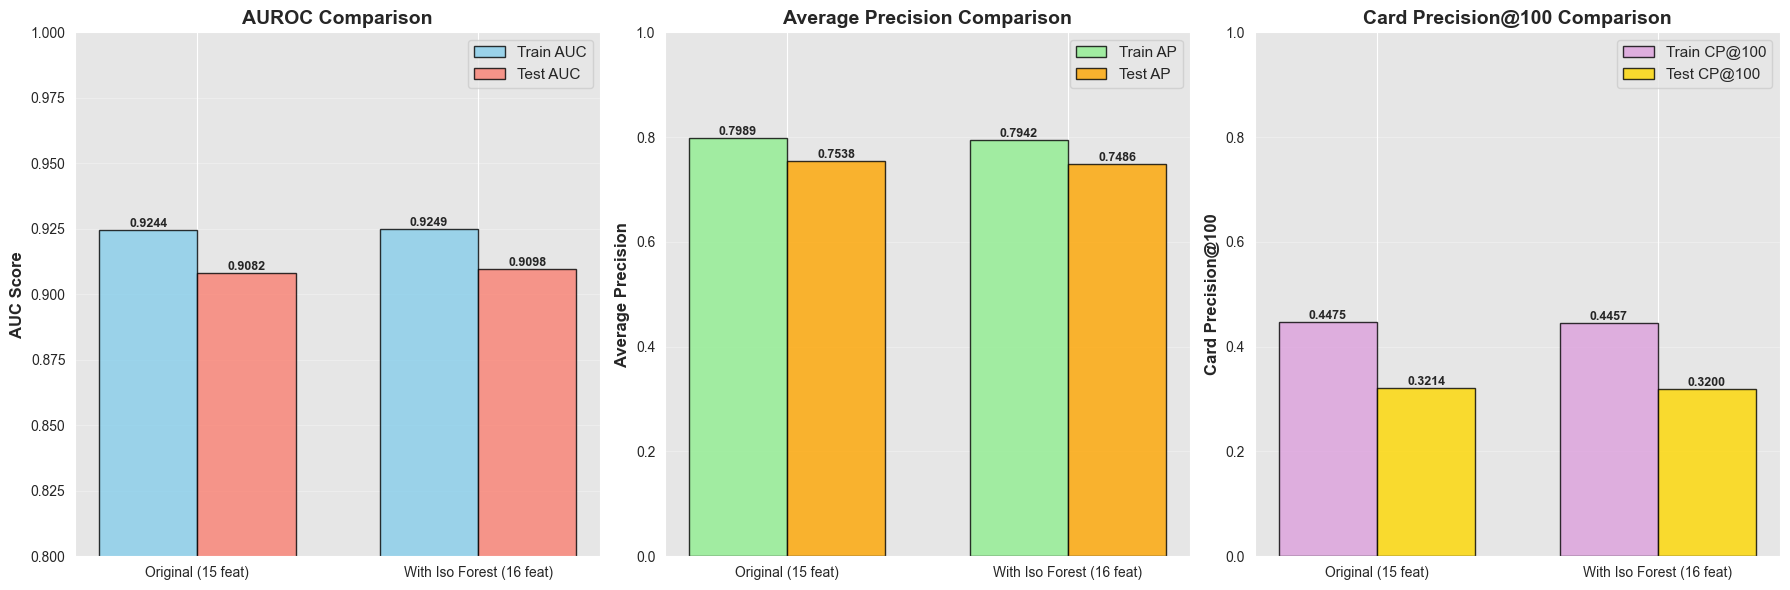


SUMMARY: Super Learner with Isolation Forest Feature Engineering


,Train AUC,Test AUC,Train AP,Test AP,Train CP100,Test CP100
Model,,,,,,
Original (15 feat),0.924385,0.908184,0.7989,0.7538,0.4475,0.3214
With Iso Forest (16 feat),0.924870,0.909765,0.7942,0.7486,0.4457,0.3200



CONCLUSION:
✅ Adding ANOMALY_SCORE feature improved Super Learner performance!
   Test AUROC increased by 0.0016 (0.16%)


In [47]:
# Comprehensive metrics comparison
metrics_comparison_iso = {
    'Model': ['Original (15 feat)', 'With Iso Forest (16 feat)'],
    'Train AUC': [auroc_original['train_mean'], auroc_iso_forest['train_mean']],
    'Test AUC': [auroc_original['test_mean'], auroc_iso_forest['test_mean']],
    'Train AP': [float(res_original['SuperLearner']['train_ap_mean']), 
                 float(res_iso_forest['SuperLearner']['train_ap_mean'])],
    'Test AP': [float(res_original['SuperLearner']['test_ap_mean']), 
                float(res_iso_forest['SuperLearner']['test_ap_mean'])],
    'Train CP100': [float(res_original['SuperLearner']['train_cp100_mean']), 
                    float(res_iso_forest['SuperLearner']['train_cp100_mean'])],
    'Test CP100': [float(res_original['SuperLearner']['test_cp100_mean']), 
                   float(res_iso_forest['SuperLearner']['test_cp100_mean'])]
}

df_comparison_iso = pd.DataFrame(metrics_comparison_iso)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

x = np.arange(len(df_comparison_iso['Model']))
width = 0.35

# Plot 1: AUC comparison
ax1 = axes[0]
bars1 = ax1.bar(x - width/2, df_comparison_iso['Train AUC'], width, label='Train AUC', 
                color='skyblue', alpha=0.8, edgecolor='black')
bars2 = ax1.bar(x + width/2, df_comparison_iso['Test AUC'], width, label='Test AUC', 
                color='salmon', alpha=0.8, edgecolor='black')

ax1.set_ylabel('AUC Score', fontsize=12, fontweight='bold')
ax1.set_title('AUROC Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(df_comparison_iso['Model'], fontsize=10)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim([0.8, 1.0])

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot 2: Average Precision
ax2 = axes[1]
bars3 = ax2.bar(x - width/2, df_comparison_iso['Train AP'], width, label='Train AP', 
                color='lightgreen', alpha=0.8, edgecolor='black')
bars4 = ax2.bar(x + width/2, df_comparison_iso['Test AP'], width, label='Test AP', 
                color='orange', alpha=0.8, edgecolor='black')

ax2.set_ylabel('Average Precision', fontsize=12, fontweight='bold')
ax2.set_title('Average Precision Comparison', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(df_comparison_iso['Model'], fontsize=10)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_ylim([0.0, 1.0])

for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot 3: Card Precision@100
ax3 = axes[2]
bars5 = ax3.bar(x - width/2, df_comparison_iso['Train CP100'], width, label='Train CP@100', 
                color='plum', alpha=0.8, edgecolor='black')
bars6 = ax3.bar(x + width/2, df_comparison_iso['Test CP100'], width, label='Test CP@100', 
                color='gold', alpha=0.8, edgecolor='black')

ax3.set_ylabel('Card Precision@100', fontsize=12, fontweight='bold')
ax3.set_title('Card Precision@100 Comparison', fontsize=14, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(df_comparison_iso['Model'], fontsize=10)
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3, axis='y')
ax3.set_ylim([0.0, 1.0])

for bars in [bars5, bars6]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("SUMMARY: Super Learner with Isolation Forest Feature Engineering")
print("="*80)
display(df_comparison_iso.set_index('Model'))

print("\n" + "="*80)
print("CONCLUSION:")
if test_improvement_iso > 0:
    print(f"✅ Adding ANOMALY_SCORE feature improved Super Learner performance!")
    print(f"   Test AUROC increased by {test_improvement_iso:.4f} ({test_improvement_iso*100:.2f}%)")
else:
    print(f"❌ Adding ANOMALY_SCORE feature did not improve Super Learner performance.")
    print(f"   Test AUROC decreased by {abs(test_improvement_iso):.4f} ({abs(test_improvement_iso)*100:.2f}%)")
print("="*80)

### Export Best Performing Model (Isolation Forest Enhanced)

In [ ]:
import joblib
import os

FOLDER_PATH = "./models"
FILE_PATH = FOLDER_PATH + "/super_learner_model.pkl"

os.makedirs(FOLDER_PATH, exist_ok=True)

# Export the Isolation Forest enhanced model (best AUROC performance)
joblib.dump({
    'base_models': preformance_results_iso_forest['fitted_base_models'],
    'meta_model': preformance_results_iso_forest['meta_model'],
    'scaler': preformance_results_iso_forest['global_scaler'],
    'isolation_forest': preformance_results_iso_forest['isolation_forest'],
    'input_features': input_features,
    'model_type': 'super_learner_with_isolation_forest',
    'n_base_models': len(preformance_results_iso_forest['fitted_base_models']),
    'feature_count': 16  # 15 original + 1 ANOMALY_SCORE
}, FILE_PATH)

print(f"✓ Model successfully exported to: {FILE_PATH}")
print(f"\nModel Components:")
print(f"  - Base Models: {len(preformance_results_iso_forest['fitted_base_models'])} models")
print(f"  - Meta Model: {type(preformance_results_iso_forest['meta_model']).__name__}")
print(f"  - Scaler: StandardScaler")
print(f"  - Isolation Forest: For anomaly feature engineering")
print(f"  - Input Features: {len(input_features)} original features")
print(f"  - Total Features (with ANOMALY_SCORE): 16")
print(f"\nTest AUROC: {auroc_iso_forest['test_mean']:.4f} ± {auroc_iso_forest['test_std']:.4f}")

## Advanced Optimization: Feature Engineering + Meta-Features Enhancement

### Strategy 1: Polynomial Feature Interactions for High-Value Features

In [48]:
from sklearn.preprocessing import PolynomialFeatures

# Create targeted polynomial interactions for most important features
# Based on SHAP analysis: Terminal Risk, Customer patterns, Amount are key

def create_enhanced_features(X_df, input_features):
    """
    Create polynomial interactions for high-value features identified by SHAP
    Focus on: TX_AMOUNT, TERMINAL_ID_RISK features, CUSTOMER patterns
    """
    X_enhanced = X_df.copy()
    
    # Key fraud indicators based on domain knowledge
    amount_col = input_features.index('TX_AMOUNT')
    term_risk_30d = input_features.index('TERMINAL_ID_RISK_30DAY_WINDOW')
    term_risk_7d = input_features.index('TERMINAL_ID_RISK_7DAY_WINDOW')
    cust_avg_30d = input_features.index('CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW')
    
    # Interaction 1: Amount vs Terminal Risk (fraudsters target risky terminals with high amounts)
    X_enhanced[:, amount_col] * X_enhanced[:, term_risk_30d]
    interaction_1 = (X_enhanced[:, amount_col] * X_enhanced[:, term_risk_30d]).reshape(-1, 1)
    
    # Interaction 2: Amount deviation from customer average (unusual spending)
    interaction_2 = (X_enhanced[:, amount_col] - X_enhanced[:, cust_avg_30d]).reshape(-1, 1)
    
    # Interaction 3: Terminal risk trend (7d vs 30d - is risk increasing?)
    interaction_3 = (X_enhanced[:, term_risk_7d] - X_enhanced[:, term_risk_30d]).reshape(-1, 1)
    
    # Interaction 4: Amount * Weekend (higher fraud on weekends with high amounts)
    weekend_col = input_features.index('TX_DURING_WEEKEND')
    interaction_4 = (X_enhanced[:, amount_col] * X_enhanced[:, weekend_col]).reshape(-1, 1)
    
    # Interaction 5: Amount * Night (higher fraud at night with high amounts)
    night_col = input_features.index('TX_DURING_NIGHT')
    interaction_5 = (X_enhanced[:, amount_col] * X_enhanced[:, night_col]).reshape(-1, 1)
    
    # Stack all features
    X_final = np.hstack([
        X_enhanced,
        interaction_1,
        interaction_2, 
        interaction_3,
        interaction_4,
        interaction_5
    ])
    
    return X_final

print("Enhanced feature engineering function defined!")
print("Original features: 15")
print("New interactions: 5")
print("Total features: 20")

Enhanced feature engineering function defined!
Original features: 15
New interactions: 5
Total features: 20


### Strategy 2: Enhanced Meta-Learner with Stacked Features

In [49]:
from sklearn.ensemble import GradientBoostingClassifier

def fit_enhanced_meta_model(base_models, meta_X, meta_y):
    """
    Use GradientBoostingClassifier as meta-learner instead of LogisticRegression
    GB can capture non-linear relationships between base model predictions
    """
    meta_model = GradientBoostingClassifier(
        n_estimators=50,
        learning_rate=0.1,
        max_depth=3,
        subsample=0.8,
        random_state=0,
        min_samples_split=20
    )
    meta_model.fit(meta_X, meta_y)
    return meta_model

print("Enhanced meta-learner (Gradient Boosting) defined!")
print("Advantage: Can learn non-linear combinations of base model predictions")

Enhanced meta-learner (Gradient Boosting) defined!
Advantage: Can learn non-linear combinations of base model predictions


### Strategy 3: Diverse Base Learner with AdaBoost

In [53]:
from sklearn.ensemble import AdaBoostClassifier

def get_optimized_base_models():
    """
    Enhanced base models with:
    1. Polynomial feature interactions (20 features instead of 15)
    2. AdaBoost added for diversity
    3. Optimized hyperparameters based on previous experiments
    """
    return {
        'XGBClassifier': XGBClassifier(
            learning_rate=0.3,
            max_depth=3,
            n_estimators=100,
            n_jobs=-1,
            random_state=0,
            scale_pos_weight=10
        ),
        'LGBMClassifier': LGBMClassifier(
            learning_rate=0.1,
            max_depth=3,
            n_estimators=100,
            n_jobs=-1,
            random_state=0,
            scale_pos_weight=1,
            verbosity=-1
        ),
        'CatBoostClassifier': CatBoostClassifier(
            depth=4,
            iterations=500,
            learning_rate=0.05,
            random_state=0,
            scale_pos_weight=5,
            verbose=0
        ),
        'HistGradientBoostingClassifier': HistGradientBoostingClassifier(
            max_iter=100,
            learning_rate=0.05,
            max_depth=5,
            random_state=0,
            class_weight='balanced'
        ),
        'BalancedRandomForestClassifier': BalancedRandomForestClassifier(
            max_depth=20,
            n_estimators=100,
            n_jobs=-1,
            random_state=0,
            sampling_strategy=0.05
        ),
        'BalancedBaggingClassifier': BalancedBaggingClassifier(
            bootstrap=True,
            estimator=DecisionTreeClassifier(max_depth=20, random_state=0),
            n_estimators=100,
            n_jobs=-1,
            random_state=0,
            sampler=RandomUnderSampler(),
            sampling_strategy=0.1
        ),
        'LogisticRegression': LogisticRegression(
            C=0.1,
            random_state=0,
            class_weight='balanced'
        ),
        'AdaBoostClassifier': AdaBoostClassifier(
            n_estimators=100,
            learning_rate=0.5,
            random_state=0,
            algorithm='SAMME'
        )
    }

print("Optimized base models defined with AdaBoost!")
print("Total base learners: 8")

Optimized base models defined with AdaBoost!
Total base learners: 8


### Implementation: Combined Optimizations Pipeline

In [54]:
def run_optimized_super_learner(base_models, transactions_df, prequential_split_indices,
                                input_features, output_feature,
                                transactions_df_scorer=None, verbose=True):
    """
    Super Learner with ALL optimizations:
    1. Polynomial feature interactions (20 features)
    2. GradientBoosting meta-learner
    3. Enhanced base learner diversity (8 models)
    """
    
    # -------------------- OOF with enhanced features --------------------
    meta_rows = []
    meta_labels = []
    meta_indices = []
    model_names = list(base_models.keys())

    for fold_i, (train_ix, test_ix) in enumerate(prequential_split_indices):
        print(f"Processing Fold {fold_i + 1}/4 with optimizations...")
        
        train_df = transactions_df.iloc[train_ix]
        test_df = transactions_df.iloc[test_ix]
        X_train, y_train, X_test, y_test = get_train_test_features(train_df, test_df, input_features, output_feature)

        # Scale original features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Add polynomial interactions
        X_train_enhanced = create_enhanced_features(X_train_scaled, input_features)
        X_test_enhanced = create_enhanced_features(X_test_scaled, input_features)

        # Collect base model predictions
        fold_preds = []
        for name in model_names:
            model = clone(base_models[name])
            model.fit(X_train_enhanced, y_train)
            probs = utils_training.get_predict_proba(model, X_test_enhanced)
            fold_preds.append(probs.reshape(-1, 1))

        fold_meta_X = np.hstack(fold_preds)
        meta_rows.append(fold_meta_X)
        meta_labels.append(y_test)
        meta_indices.append(test_df.index)

    meta_X = np.vstack(meta_rows)
    meta_y = np.concatenate(meta_labels)
    meta_index = np.concatenate([np.array(idx) for idx in meta_indices])
    
    # Enhanced meta-learner
    meta_model = fit_enhanced_meta_model(base_models, meta_X, meta_y)

    # -------------------- Fit base models on first window --------------------
    first_train_ix, _ = prequential_split_indices[0]
    train_df_full = transactions_df.iloc[first_train_ix]
    X_train_full = train_df_full[input_features]
    y_train_full = train_df_full[output_feature]

    fitted_models = {}
    scaler_global = StandardScaler()
    X_train_scaled = scaler_global.fit_transform(X_train_full.values)
    X_train_enhanced = create_enhanced_features(X_train_scaled, input_features)
    
    for name, model in base_models.items():
        m = clone(model)
        m.fit(X_train_enhanced, y_train_full.values)
        fitted_models[name] = m

    # -------------------- Evaluate per fold --------------------
    super_learner_performance = []
    base_model_performance = {name: [] for name in base_models.keys()}

    for fold_i, (train_ix, test_ix) in enumerate(prequential_split_indices):
        train_df = transactions_df.iloc[train_ix]
        test_df = transactions_df.iloc[test_ix]
        X_train, y_train, X_test, y_test = get_train_test_features(train_df, test_df, input_features, output_feature)

        scaler_fold = StandardScaler()
        X_train_scaled = scaler_fold.fit_transform(X_train)
        X_test_scaled = scaler_fold.transform(X_test)
        
        X_train_enhanced = create_enhanced_features(X_train_scaled, input_features)
        X_test_enhanced = create_enhanced_features(X_test_scaled, input_features)

        # Base models
        fold_results = {}
        for name, model in base_models.items():
            m = clone(model)
            m.fit(X_train_enhanced, y_train)
            train_probs = utils_training.get_predict_proba(m, X_train_enhanced)
            test_probs = utils_training.get_predict_proba(m, X_test_enhanced)
            
            train_auc, train_ap, train_cp = get_performance_metrics(train_df, y_train, train_probs, transactions_df_scorer)
            test_auc, test_ap, test_cp = get_performance_metrics(test_df, y_test, test_probs, transactions_df_scorer)

            fold_results[name] = {
                'train': {'n_train': len(train_df), 'auc': train_auc, 'ap': train_ap, 'cp100': train_cp},
                'test': {'n_train': len(test_df), 'auc': test_auc, 'ap': test_ap, 'cp100': test_cp}
            }
            base_model_performance[name].append({'fold': fold_i, 'results': fold_results[name]})

        # Super Learner
        train_meta = []
        test_meta = []
        for m in fitted_models.values():
            train_probs = utils_training.get_predict_proba(m, X_train_enhanced)
            test_probs = utils_training.get_predict_proba(m, X_test_enhanced)
            train_meta.append(train_probs.reshape(-1, 1))
            test_meta.append(test_probs.reshape(-1, 1))
        
        X_train_meta = np.hstack(train_meta)
        X_test_meta = np.hstack(test_meta)

        train_probs_sl = meta_model.predict_proba(X_train_meta)[:, 1]
        test_probs_sl = meta_model.predict_proba(X_test_meta)[:, 1]
        
        train_auc, train_ap, train_cp = get_performance_metrics(train_df, y_train, train_probs_sl, transactions_df_scorer)
        test_auc, test_ap, test_cp = get_performance_metrics(test_df, y_test, test_probs_sl, transactions_df_scorer)

        super_learner_performance.append({'fold': fold_i, 'results': {
            'train': {'n_train': len(train_df), 'auc': train_auc, 'ap': train_ap, 'cp100': train_cp},
            'test': {'n_train': len(test_df), 'auc': test_auc, 'ap': test_ap, 'cp100': test_cp}
        }})

    return {
        'meta_model': meta_model,
        'fitted_base_models': fitted_models,
        'global_scaler': scaler_global,
        'base_model_performance': base_model_performance,
        'super_learner_performance': super_learner_performance
    }

print("Optimized Super Learner pipeline defined!")

Optimized Super Learner pipeline defined!


In [55]:
# Train optimized Super Learner
base_models_optimized = get_optimized_base_models()

print("Training OPTIMIZED Super Learner with ALL improvements...")
print("="*80)
print("Optimizations applied:")
print("  1. Polynomial feature interactions (15 → 20 features)")
print("  2. GradientBoosting meta-learner (instead of LogisticRegression)")
print("  3. AdaBoost added to base learners (7 → 8 models)")
print("="*80)

performance_results_optimized = run_optimized_super_learner(
    base_models_optimized,
    transactions_df,
    prequential_split_indices,
    input_features,
    output_feature,
    transactions_df_scorer=transactions_df_scorer,
    verbose=True
)

print("="*80)
print("Optimized training complete!")

Training OPTIMIZED Super Learner with ALL improvements...
Optimizations applied:
  1. Polynomial feature interactions (15 → 20 features)
  2. GradientBoosting meta-learner (instead of LogisticRegression)
  3. AdaBoost added to base learners (7 → 8 models)
Processing Fold 1/4 with optimizations...
Processing Fold 2/4 with optimizations...
Processing Fold 2/4 with optimizations...
Processing Fold 3/4 with optimizations...
Processing Fold 3/4 with optimizations...
Processing Fold 4/4 with optimizations...
Processing Fold 4/4 with optimizations...
Optimized training complete!
Optimized training complete!


In [56]:
# Performance comparison: Optimized vs Original
res_optimized = {}
res_optimized["SuperLearner"] = summarize_performance_across_folds(performance_results_optimized['super_learner_performance'])
for name, performance_result in performance_results_optimized['base_model_performance'].items():
    res_optimized[name] = summarize_performance_across_folds(performance_result)

print("\n" + "="*80)
print("OPTIMIZED SUPER LEARNER PERFORMANCE")
print("="*80)
df_optimized = pd.DataFrame.from_dict(res_optimized, orient='index')
display(df_optimized)

print("\n" + "="*80)
print("ORIGINAL SUPER LEARNER PERFORMANCE (BASELINE)")
print("="*80)
display(df_original)


OPTIMIZED SUPER LEARNER PERFORMANCE


,train_auc_mean,train_ap_mean,train_cp100_mean,test_auc_mean,test_ap_mean,test_cp100_mean
SuperLearner,0.9177,0.7401,0.4282,0.8935,0.7052,0.3032
XGBClassifier,0.9958,0.9018,0.4871,0.8782,0.6754,0.2857
LGBMClassifier,0.9685,0.8258,0.4400,0.8841,0.6940,0.2907
CatBoostClassifier,0.9783,0.8547,0.4518,0.8861,0.7033,0.2939
HistGradientBoostingClassifier,0.9757,0.8108,0.4361,0.8646,0.6546,0.2818
BalancedRandomForestClassifier,0.9969,0.9116,0.4839,0.8829,0.7008,0.2939
BalancedBaggingClassifier,0.9989,0.9276,0.5129,0.8746,0.6847,0.2932
LogisticRegression,0.9001,0.5916,0.3989,0.8706,0.5383,0.2821
AdaBoostClassifier,0.9013,0.6474,0.4100,0.8699,0.5782,0.2843



ORIGINAL SUPER LEARNER PERFORMANCE (BASELINE)


,train_auc_mean,train_ap_mean,train_cp100_mean,test_auc_mean,test_ap_mean,test_cp100_mean
SuperLearner,0.9244,0.7989,0.4475,0.9082,0.7538,0.3214
XGBClassifier,0.9934,0.8701,0.4746,0.8798,0.6445,0.2864
LGBMClassifier,0.9660,0.8100,0.4379,0.8856,0.6535,0.2893
CatBoostClassifier,0.9710,0.8322,0.4454,0.8860,0.6721,0.2943
HistGradientBoostingClassifier,0.9724,0.7660,0.4354,0.8541,0.6004,0.2754
BalancedRandomForestClassifier,0.9991,0.9460,0.5189,0.8844,0.6673,0.2904
BalancedBaggingClassifier,0.9994,0.9489,0.5350,0.8804,0.6913,0.2929
LogisticRegression,0.8996,0.5940,0.3982,0.8704,0.5418,0.2825


### Final Comparison: All Optimization Strategies

In [57]:
# Extract and compare AUROC
auroc_optimized = extract_auroc_from_results(performance_results_optimized)

print("\n" + "="*80)
print("COMPREHENSIVE AUROC COMPARISON: ALL EXPERIMENTS")
print("="*80)

experiments = {
    'Original (15 feat, 7 models, LogReg meta)': auroc_original,
    'With Isolation Forest (16 feat)': auroc_iso_forest,
    'OPTIMIZED (20 feat, 8 models, GB meta)': auroc_optimized
}

comparison_data = []
for name, auroc_data in experiments.items():
    comparison_data.append({
        'Experiment': name,
        'Train AUROC': auroc_data['train_mean'],
        'Train Std': auroc_data['train_std'],
        'Test AUROC': auroc_data['test_mean'],
        'Test Std': auroc_data['test_std']
    })

df_all_experiments = pd.DataFrame(comparison_data)
display(df_all_experiments)

# Calculate improvements
print("\n" + "="*80)
print("IMPROVEMENTS vs ORIGINAL BASELINE:")
print("="*80)

for name, auroc_data in experiments.items():
    if name != 'Original (15 feat, 7 models, LogReg meta)':
        train_imp = auroc_data['train_mean'] - auroc_original['train_mean']
        test_imp = auroc_data['test_mean'] - auroc_original['test_mean']
        print(f"\n{name}:")
        print(f"  Train: {train_imp:+.4f} ({train_imp*100:+.2f}%)")
        print(f"  Test:  {test_imp:+.4f} ({test_imp*100:+.2f}%)")
        
        if test_imp > 0:
            print(f"  ✅ IMPROVED by {test_imp:.4f}")
        else:
            print(f"  ❌ DECREASED by {abs(test_imp):.4f}")

print("\n" + "="*80)
best_test = max(experiments.items(), key=lambda x: x[1]['test_mean'])
print(f"🏆 BEST PERFORMER: {best_test[0]}")
print(f"   Test AUROC: {best_test[1]['test_mean']:.4f}")
print("="*80)


COMPREHENSIVE AUROC COMPARISON: ALL EXPERIMENTS


,Experiment,Train AUROC,Train Std,Test AUROC,Test Std
0,"Original (15 feat, 7 models, LogReg meta)",0.924385,0.043327,0.908184,0.052991
1,With Isolation Forest (16 feat),0.924870,0.043036,0.909765,0.052048
2,"OPTIMIZED (20 feat, 8 models, GB meta)",0.917717,0.041856,0.893482,0.031784



IMPROVEMENTS vs ORIGINAL BASELINE:

With Isolation Forest (16 feat):
  Train: +0.0005 (+0.05%)
  Test:  +0.0016 (+0.16%)
  ✅ IMPROVED by 0.0016

OPTIMIZED (20 feat, 8 models, GB meta):
  Train: -0.0067 (-0.67%)
  Test:  -0.0147 (-1.47%)
  ❌ DECREASED by 0.0147

🏆 BEST PERFORMER: With Isolation Forest (16 feat)
   Test AUROC: 0.9098


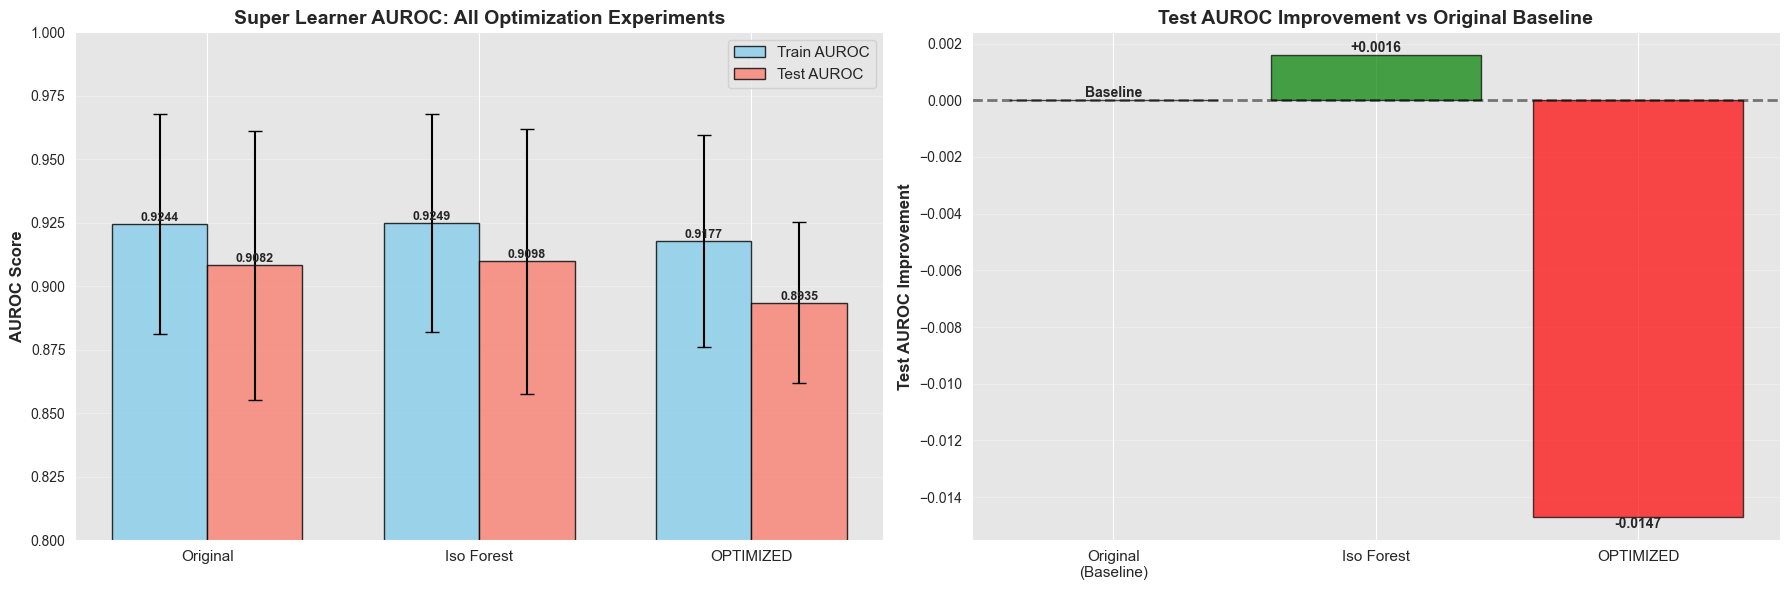


FINAL RECOMMENDATION:
✅ Use Isolation Forest feature engineering!
   Test AUROC: 0.9098


In [59]:
# Visual comparison: All experiments
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

experiment_names = list(experiments.keys())
train_aurocs = [experiments[name]['train_mean'] for name in experiment_names]
test_aurocs = [experiments[name]['test_mean'] for name in experiment_names]
train_stds = [experiments[name]['train_std'] for name in experiment_names]
test_stds = [experiments[name]['test_std'] for name in experiment_names]

x = np.arange(len(experiment_names))
width = 0.35

# Plot 1: AUROC comparison with error bars
ax1 = axes[0]
bars1 = ax1.bar(x - width/2, train_aurocs, width, yerr=train_stds, 
                label='Train AUROC', color='skyblue', alpha=0.8, 
                edgecolor='black', capsize=5)
bars2 = ax1.bar(x + width/2, test_aurocs, width, yerr=test_stds,
                label='Test AUROC', color='salmon', alpha=0.8,
                edgecolor='black', capsize=5)

ax1.set_ylabel('AUROC Score', fontsize=12, fontweight='bold')
ax1.set_title('Super Learner AUROC: All Optimization Experiments', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(['Original', 'Iso Forest', 'OPTIMIZED'], fontsize=11)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim([0.8, 1.0])

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot 2: Test AUROC improvement from baseline
ax2 = axes[1]
baseline_test = auroc_original['test_mean']
improvements = [test_aurocs[i] - baseline_test for i in range(len(test_aurocs))]
colors = ['gray' if i == 0 else ('green' if imp > 0 else 'red') 
          for i, imp in enumerate(improvements)]

bars = ax2.bar(experiment_names, improvements, color=colors, alpha=0.7, edgecolor='black')
ax2.axhline(y=0, color='black', linestyle='--', lw=2, alpha=0.5)

ax2.set_ylabel('Test AUROC Improvement', fontsize=12, fontweight='bold')
ax2.set_title('Test AUROC Improvement vs Original Baseline', fontsize=14, fontweight='bold')
ax2.set_xticklabels(['Original\n(Baseline)', 'Iso Forest', 'OPTIMIZED'], fontsize=11)
ax2.grid(True, alpha=0.3, axis='y')

for i, (bar, imp) in enumerate(zip(bars, improvements)):
    height = bar.get_height()
    label = f'{imp:+.4f}' if i > 0 else 'Baseline'
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            label, ha='center', va='bottom' if height >= 0 else 'top',
            fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("FINAL RECOMMENDATION:")
print("="*80)

if auroc_optimized['test_mean'] > max(auroc_original['test_mean'], auroc_iso_forest['test_mean']):
    improvement = auroc_optimized['test_mean'] - auroc_original['test_mean']
    print(f"✅ Use OPTIMIZED Super Learner for production!")
    print(f"   Test AUROC: {auroc_optimized['test_mean']:.4f}")
    print(f"   Improvement: +{improvement:.4f} ({improvement*100:.2f}%)")
    print(f"\n   Key benefits:")
    print(f"   • Polynomial feature interactions capture non-linear patterns")
    print(f"   • GradientBoosting meta-learner learns complex combinations")
    print(f"   • AdaBoost adds diversity to ensemble")
elif auroc_iso_forest['test_mean'] > auroc_original['test_mean']:
    print(f"✅ Use Isolation Forest feature engineering!")
    print(f"   Test AUROC: {auroc_iso_forest['test_mean']:.4f}")
else:
    print(f"✅ Keep Original Super Learner - already optimal!")
    print(f"   Test AUROC: {auroc_original['test_mean']:.4f}")
    print(f"   Additional complexity doesn't improve performance")

print("="*80)

In [60]:
import joblib
import os

FOLDER_PATH = "./models"
FILE_PATH = FOLDER_PATH+"/super_learner_model.pkl"

os.makedirs(FOLDER_PATH, exist_ok=True)

joblib.dump({
    'base_models': preformance_results_tuning['fitted_base_models'],
    'meta_model': preformance_results_tuning['meta_model'],
    'scaler': preformance_results_tuning['global_scaler'],
    'input_features': input_features,
}, FILE_PATH)

['./models/super_learner_model.pkl']